# Big Data Platform: Yelp Review Analysis

This dataset is a subset of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge.

The name of the user that has summitted more reviews is Stefany with more than 1000 reviews. Most of the top users are from LA, as we could expected, as well as from Phoenix and Charlotte. 

In [1]:
#import statements
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.functions import udf

In [2]:
spark = SparkSession.builder.appName('yelpreviewdataset').getOrCreate()
# #change configuration settings on Spark 
# conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

# #print spark configuration settings
# spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/pyspark.zip'),
 ('spark.yarn.historyServer.addre

## Exploratory Data Analysis

### 1.1 Read & Combine Datasets

We will be combining 3 separate datasets: business, reviews and users. We will then procced to some data cleaning in order to have a dataset easier to work with. Althouh there were two more datasets (photo and reviews) from the original Yelp dataset, we decide not to use them for the purpose of this project.

In [3]:
df_business = spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_business.json")

In [4]:
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [5]:
print('There are',df_business.count(),'of business the yelp business dataset')

There are 192609 of business the yelp business dataset


In [6]:
#change name for starts to avoid duplicates
df_business=df_business.withColumnRenamed("stars", "Restaurant_stars")
df_business=df_business.withColumnRenamed("name", "Restaurant_name")

In [7]:
#only keep restaurant in business table for this project
df_business=df_business.filter(psf.col('categories').rlike('Restaurants'))

In [8]:
print('There are',df_business.count(),'of restaurant in the yelp business dataset')

There are 59371 of restaurant in the yelp business dataset


In [9]:
#may be need to clean up this column a bit more
df_business.select('attributes').show(10)

+--------------------+
|          attributes|
+--------------------+
|[,, u'full_bar', ...|
|[,, u'beer_and_wi...|
|[,, u'none', {'ro...|
|[,, u'none', None...|
|[,, u'full_bar', ...|
|[,,, {'touristy':...|
|[,, u'beer_and_wi...|
|[,,,,,,, True,,, ...|
|[,, u'full_bar', ...|
|[,, u'full_bar',,...|
+--------------------+
only showing top 10 rows



Business to drop:
* address, post_code
* latitude, longtitude

In [10]:
columns_to_drop = ['address','postal_code','latitude','longitude','review_count']
df_business = df_business.drop(*columns_to_drop)

In [11]:
df_business.limit(3).toPandas()

attributes             business_id  \
0  (None, None, u'full_bar', {'romantic': False, ...  QXAEGFB4oINsVuTFxEYKFQ   
1  (None, None, u'beer_and_wine', {'romantic': Fa...  gnKjwL_1w79qoiV3IC_xQQ   
2  (None, None, u'none', {'romantic': False, 'int...  1Dfx3zM-rW4n-31KeC8sJg   

                                          categories         city  \
0  Specialty Food, Restaurants, Dim Sum, Imported...  Mississauga   
1                  Sushi Bars, Restaurants, Japanese    Charlotte   
2  Restaurants, Breakfast & Brunch, Mexican, Taco...      Phoenix   

                                               hours  is_open  \
0  (9:0-1:0, 9:0-0:0, 9:0-1:0, 9:0-0:0, 9:0-0:0, ...        1   
1  (17:30-22:0, 17:30-21:30, 17:30-22:0, 17:30-21...        1   
2  (7:0-1:0, 7:0-0:0, 7:0-1:0, 7:0-0:0, 7:0-1:0, ...        1   

               Restaurant_name  Restaurant_stars state  
0   Emerald Chinese Restaurant               2.5    ON  
1  Musashi Japanese Restaurant               4.0    NC  
2                    Taco Bell               3.0    AZ

In [12]:
df_reviews =  spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_review.json")

In [13]:
df_reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



Reviews to drop:
    - cool, funny 
    - average_starts

In [14]:
columns_to_drop = ['cool','funny','average_stars']
df_reviews = df_reviews.drop(*columns_to_drop)

In [15]:
df_reviews.limit(3).toPandas()

business_id                 date               review_id  stars  \
0  ujmEBvifdJM6h6RLv4wQIg  2013-05-07 04:34:36  Q1sbwvVQXV2734tPgoKj4Q    1.0   
1  NZnhc2sEQy3RmzKTZnqtwQ  2017-01-14 21:30:33  GJXCdrto3ASJOqKeVWPi6Q    5.0   
2  WTqjgwHlXbSFevF32_DJVw  2016-11-09 20:09:03  2TzJjDVDEuAW6MR5Vuc1ug    5.0   

                                                text  useful  \
0  Total bill for this horrible service? Over $8G...       6   
1  I *adore* Travis at the Hard Rock's new Kelly ...       0   
2  I have to say that this office really has it t...       3   

                  user_id  
0  hG7b0MtEbXx5QzbzE6C_VA  
1  yXQM5uF2jS6es16SJzNHfg  
2  n6-Gk65cPZL6Uz8qRm3NYw

In [16]:
df_user =  spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_user.json")

In [17]:
df_user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



User to drop:
    - elite, yelping_since 
    - useful, review_count

In [18]:
df_user.limit(3).toPandas()

average_stars  compliment_cool  compliment_cute  compliment_funny  \
0           4.03                1                0                 1   
1           3.63                1                0                 1   
2           3.71                0                0                 0   

   compliment_hot  compliment_list  compliment_more  compliment_note  \
0               2                0                0                1   
1               1                0                0                0   
2               0                0                0                1   

   compliment_photos  compliment_plain         ...           cool  \
0                  0                 1         ...             25   
1                  0                 0         ...             16   
2                  0                 0         ...             10   

            elite  fans                                            friends  \
0  2015,2016,2017     5  c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...   
1                     4  kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...   
2                     0  4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...   

   funny    name  review_count useful                 user_id  \
0     17  Rashmi            95     84  l6BmjZMeQD3rDxWUbiAiow   
1     22   Jenna            33     48  4XChL029mKr5hydo79Ljxg   
2      8   David            16     28  bc8C_eETBWL0olvFSJJd0w   

         yelping_since  
0  2013-10-08 23:11:33  
1  2013-02-21 22:29:06  
2  2013-10-04 00:16:10  

[3 rows x 22 columns]

In [19]:
columns_to_drop = ['elite','useful','yelping_since','review_count']
df_user = df_user.drop(*columns_to_drop)

In [20]:
df_user=df_user.withColumnRenamed("name", "user_name")

In [21]:
#join three tables into one table in case need for future
df = df_reviews.join(df_business,on ='business_id', how = 'inner')
df = df.join(df_user,on ='user_id', how = 'inner')

In [22]:
df.limit(3).toPandas()

user_id             business_id                 date  \
0  -0Ji0nOyFe-4yo8BK4aRLA  pmrHuQiy25xKB86tbOLBlA  2014-03-21 17:09:59   
1  -1KKYzibGPyUX-MwkBTlrg  L772e6l2Yd0DJEyCBxBNng  2014-09-19 01:12:10   
2  -1zQA2f_syMAdA04PUWNNw  aNe8ofTYrealxqv7VtFTuw  2016-07-29 19:44:01   

                review_id  stars  \
0  a0r23pA6D4HDLb9P5gmQkA    4.0   
1  TbU3S2kWmfajlVov3I9EKw    4.0   
2  08j8zUlyJylKcJa_rIeB-w    5.0   

                                                text  useful  \
0  They ran out of cobbler.  Gee dang it, that co...       0   
1  Swung by this place while I was up in Madison ...       1   
2  I came in today parched! My server Tannie imme...       0   

                                          attributes  \
0  (None, None, u'full_bar', {'touristy': False, ...   
1  (None, None, u'full_bar', {'romantic': False, ...   
2  (None, None, u'full_bar', {'romantic': False, ...   

                                          categories       city    ...      \
0                French, Restaurants, American (New)   Matthews    ...       
1  Sports Bars, Restaurants, American (Traditiona...    Madison    ...       
2  Pubs, Sports Bars, Pizza, Nightlife, Food, Bre...  Las Vegas    ...       

  compliment_note  compliment_photos compliment_plain  compliment_profile  \
0               0                  0                0                   0   
1               8                  0                1                   0   
2               0                  0                0                   0   

  compliment_writer  cool  fans  \
0                 0    21     0   
1                 0    54     8   
2                 0     0     0   

                                             friends  funny  user_name  
0  MXaSUovIC5U8d4GYzi2eoQ, EmdUN-cFy25hTj2lcD4Ryw...     77       cubs  
1  4NKTLRuxT5etbNOK53QL3w, a3riT5uvhETcvHssPUEPWQ...     31     Nickie  
2  J-lQl_8bKKojp32Jb3H2Rg, fFxOSG41WngPfdurA4l8Ag...      3       Zach  

[3 rows x 32 columns]

### 1.2 Data Cleaning and Processing variables

In [23]:
df.count()

4201684

In [24]:
df.head()

Row(user_id='-0Ji0nOyFe-4yo8BK4aRLA', business_id='pmrHuQiy25xKB86tbOLBlA', date='2014-03-21 17:09:59', review_id='a0r23pA6D4HDLb9P5gmQkA', stars=4.0, text='They ran out of cobbler.  Gee dang it, that cobbler looked good.', useful=0, attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="u'full_bar'", Ambience="{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': True, 'trendy': False, 'upscale': False, 'classy': True, 'casual': False}", BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", ByAppointmentOnly=None, Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='False', GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV='False', Music=None, NoiseLevel="u'average'", Open

In [25]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = 

In [26]:
df.describe()

DataFrame[summary: string, user_id: string, business_id: string, date: string, review_id: string, stars: string, text: string, useful: string, categories: string, city: string, is_open: string, Restaurant_name: string, Restaurant_stars: string, state: string, average_stars: string, compliment_cool: string, compliment_cute: string, compliment_funny: string, compliment_hot: string, compliment_list: string, compliment_more: string, compliment_note: string, compliment_photos: string, compliment_plain: string, compliment_profile: string, compliment_writer: string, cool: string, fans: string, friends: string, funny: string, user_name: string]

#### 1.2.1. Drop columns

In [27]:
# friends do not provide any information; average_starts and Restaurant_starts are redudant information
columns_drop = ['friends','average_stars', 'Restaurant_stars', 'hours']
df = df.drop(*columns_drop)

In [28]:
columns_drop = ['compliment_cute','compliment_funny', 'compliment_hot', 'compliment_list','compliment_more','compliment_note', 
         'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer']
df = df.drop(*columns_drop)

#### 1.2.2. Treat Null values

In [29]:
df.dropna().count()

4183952

In [30]:
df = df.dropna()

#### 1.2.3. Convert types of variables

In [31]:
from pyspark.sql import functions as f
import datetime
from pyspark.sql.functions import year
from pyspark.sql.functions import month

In [32]:
df = df.withColumn('date', f.to_date(f.unix_timestamp('date', 'yyyy-MM-dd HH:mm:ss').cast('timestamp')))
df = df.withColumn('year', year(col('date')))
df = df.withColumn('stars', df['stars'].cast('int'))

In [33]:
df.dtypes

[('user_id', 'string'),
 ('business_id', 'string'),
 ('date', 'date'),
 ('review_id', 'string'),
 ('stars', 'int'),
 ('text', 'string'),
 ('useful', 'bigint'),
 ('attributes',
  'struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAcce

### 1.3 Data Visualization

As we want to focus on recommendation for similar users as well as based on reviews and restaurants, we tried to capture the relationship of variables and how they behave among each other. 

In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import split,explode
plt.style.use('ggplot')

#### 1.3.1 BUSINESSES

In [35]:
# we will only keep data from the US
df_business = df_business.filter(df_business.state != 'ON')
df_business = df_business.filter(df.city != 'Montréal')
df_business = df_business.filter(df.city != 'Toronto')

In [36]:
df_open = df_business.groupBy('is_open').count().toPandas()

In [37]:
df_open

is_open  count
0        0  11840
1        1  28915

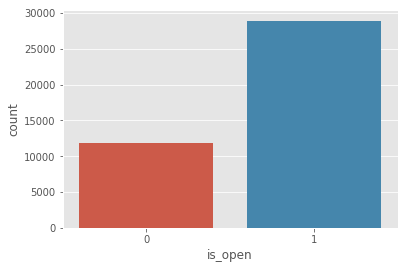

In [38]:
#sns.set_style('white')
sns.barplot(x='is_open', y='count', data=df_open)

**Quantity of opened restaurants**   
Most of the restaurants in the dataset are cunrrently open. About 11840 businesses are closed.

In [39]:
loc = df_business.groupBy('state').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
loc.head()

state  count
0    AZ  11465
1    NV   7783
2    OH   5521
3    NC   4326
4    PA   4001

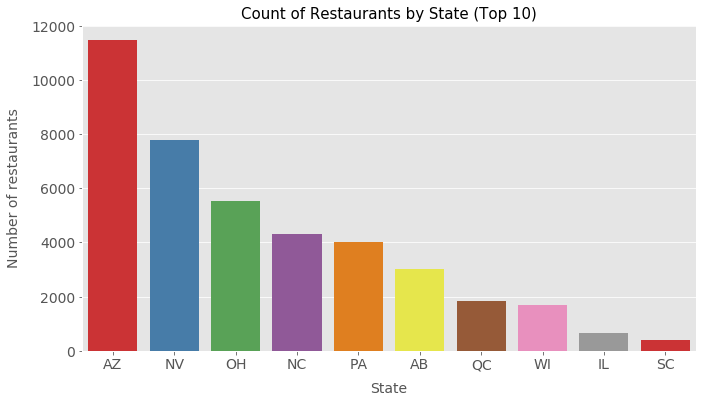

In [40]:
plt.figure(figsize=(11,6))
sns.barplot(loc['state'].values[:10], loc['count'].values[:10], 
            palette=sns.color_palette("Set1"))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('State', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by State (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=0)
plt.show()

In [41]:
state_avg = df_business.groupBy('city','state').count().groupBy('state').agg({'count':'avg'}).sort(desc('avg(count)')).toPandas()
state_avg = state_avg.round(0)
state_avg.head()


state  avg(count)
0    NV       338.0
1    AZ       201.0
2    AB       190.0
3    NC        98.0
4    WI        59.0

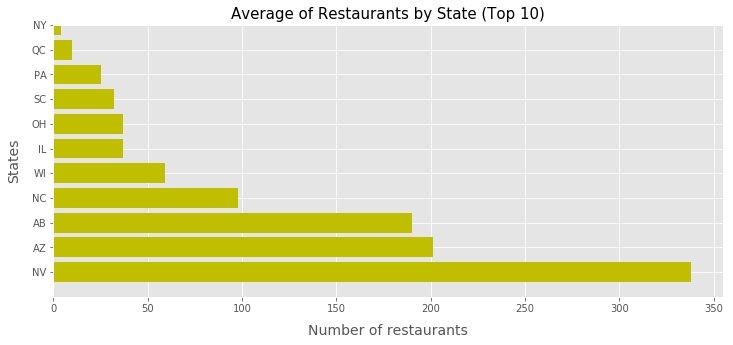

In [42]:
plt.figure(figsize=(12,5))
plt.barh(state_avg.state.values, state_avg['avg(count)'],
        color = 'y')
plt.title("Average of Restaurants by State (Top 10)", fontsize=15)
plt.xlabel("Number of restaurants", fontsize = 14, labelpad =10)
plt.ylabel("States", fontsize = 14, labelpad=10)

plt.ylim((-1,10))
plt.show()

In [43]:
loc = df_business.groupBy('city').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
loc.head()

city  count
0   Las Vegas   6450
1     Phoenix   3999
2     Calgary   2912
3   Charlotte   2710
4  Pittsburgh   2453

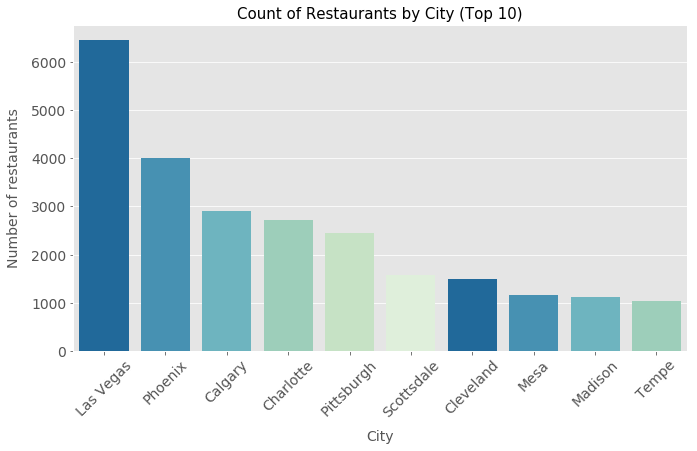

In [44]:
plt.figure(figsize=(11,6))
sns.barplot(loc['city'].values[:10], loc['count'].values[:10], 
            palette=sns.color_palette("GnBu_r"))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=45)
plt.show()

**Number of restaurants**   
Arizona state is the one with the largest number of restaurants and Las Vegas leads by far the top 10 cities with more restaurants in the USA. NV is also the state that has on average more restaurants per city. 

In [45]:
category = df.select('categories')
indi_category = category.select(explode(split('categories', ',')).alias('category'))
group_category = indi_category.groupBy('category').count()
top_category = group_category.sort('count', ascending= False)
top_category.show(10, truncate=False)

+-----------------------+-------+
|category               |count  |
+-----------------------+-------+
| Restaurants           |3138330|
|Restaurants            |1045622|
| Food                  |938825 |
| Nightlife             |847951 |
| Bars                  |831127 |
| American (Traditional)|603177 |
| American (New)        |585727 |
| Breakfast & Brunch    |524778 |
| Sandwiches            |369592 |
| Burgers               |323311 |
+-----------------------+-------+
only showing top 10 rows



In [46]:
top_category = top_category.toPandas()
top_category = top_category[2:12]
top_category

category   count
2                      Food  938825
3                 Nightlife  847951
4                      Bars  831127
5    American (Traditional)  603177
6            American (New)  585727
7        Breakfast & Brunch  524778
8                Sandwiches  369592
9                   Burgers  323311
10                  Italian  297382
11                    Pizza  296482

In [47]:
#maybe review these categories

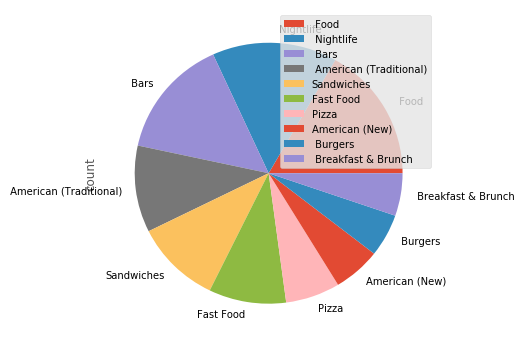

In [48]:
top_category.plot.pie(y='count', labels = [' Food', ' Nightlife', ' Bars',
       ' American (Traditional)','Sandwiches', 'Fast Food', 'Pizza', 'American (New)',
        ' Burgers', ' Breakfast & Brunch'], figsize=(6,6))


In [49]:
df_cuisine = df.groupBy('categories').count()
df_cuisine = df_cuisine.toPandas()

In [50]:
df_cuisine.loc[df_cuisine.categories.str.contains('American'),'category'] = 'American'
df_cuisine.loc[df_cuisine.categories.str.contains('Mexican'),'category'] = 'Mexican'
df_cuisine.loc[df_cuisine.categories.str.contains('Italian'),'category'] = 'Italian'
df_cuisine.loc[df_cuisine.categories.str.contains('Chinese'),'category'] = 'Chinese'
df_cuisine.loc[df_cuisine.categories.str.contains('Japanese'),'category'] = 'Japanese'
df_cuisine.loc[df_cuisine.categories.str.contains('French'),'category'] = 'French'
df_cuisine.loc[df_cuisine.categories.str.contains('Thai'),'category'] = 'Thai'
df_cuisine.loc[df_cuisine.categories.str.contains('Vietnamese'),'category'] = 'Vietnamese'
df_cuisine.loc[df_cuisine.categories.str.contains('Indian'),'category'] = 'Indian'
df_cuisine.loc[df_cuisine.categories.str.contains('Korean'),'category'] = 'Korean'
df_cuisine.loc[df_cuisine.categories.str.contains('Greek'),'category'] = 'Greek'

In [51]:
df_cuisine = df_cuisine.dropna()
df_cuisine.groupby('category').count().sort_values('count')
df_cuisine[:10]

categories  count  category
0    Italian, French, Steakhouses, Pizza, Restaurants    510    French
1   American (New), Bars, Nightlife, Italian, Medi...   1815   Italian
2   Sports Bars, Steakhouses, American (Traditiona...    271  American
3   Breakfast & Brunch, Burgers, Sandwiches, Resta...   2583  American
4   Food, Barbeque, Restaurants, American (Traditi...     56  American
7   Event Planning & Services, Caterers, Indian, R...   1485    Indian
8            Chinese, Nightlife, Karaoke, Restaurants     12   Chinese
11  Restaurants, Breakfast & Brunch, Sandwiches, A...    457  American
12  Gastropubs, American (New), Restaurants, Ameri...     25  American
13           Food, Restaurants, Coffee & Tea, Italian     10   Italian

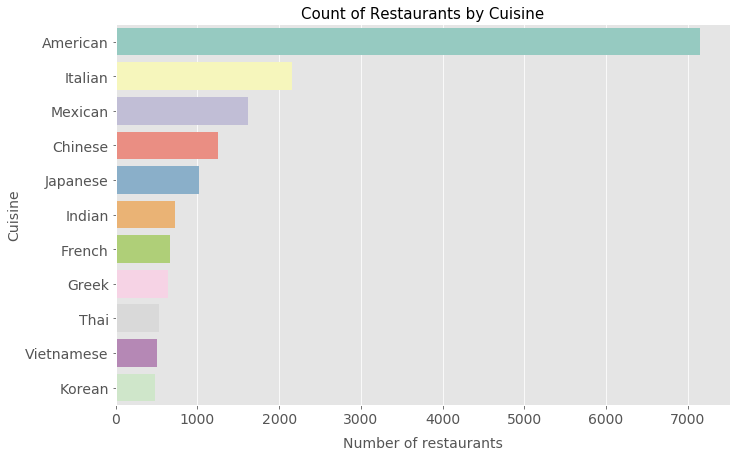

In [52]:
plt.figure(figsize=(11,7))
grouped = df_cuisine.categories.value_counts()
sns.countplot(y='category', data=df_cuisine,
              order = df_cuisine['category'].value_counts().index,
               palette= sns.color_palette("Set3"))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Cuisine', fontsize=14)
plt.title('Count of Restaurants by Cuisine', fontsize=15)
plt.tick_params(labelsize=14)

When we look at the categories, most of the businesses are Restaurants, Bars and Nightlife spaces.
Most of the restaurants are considered american cuisine. The cuisines well represented in the dataset are: Italian and Mexican. 

#### 1.3.2 Reviews

In [53]:
# we will only keep data from the US
df = df.filter(df.state != 'ON')
df = df.filter(df.city != 'Montréal')
df = df.filter(df.city != 'Toronto')

In [54]:
reviews_res = df.groupBy('year').count().orderBy('count').toPandas()
reviews_res = reviews_res.dropna()
reviews_res.head()

year  count
0  2004.0      8
1  2005.0    582
3  2006.0   3537
4  2007.0  13974
5  2008.0  35307

Text(0.5,1,'Total reviews recieved over time')

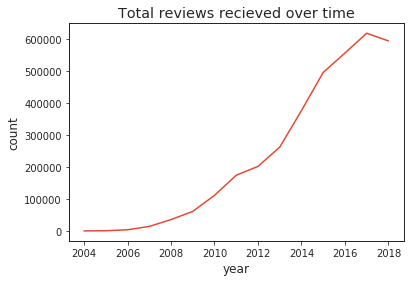

In [55]:
sns.set_style('ticks')
sns.lineplot(x="year", y="count", data=reviews_res).set_title('Total reviews recieved over time')


From the information in the dataset, 2017, seems to be the year with the largest number of reviews recieved. From 2010 to 2016, we can see an exponential grow in terms of the number  reviews.

In [56]:
from pyspark.sql.functions import date_format

In [57]:
df = df.withColumn("dow_number", date_format('date', 'u').alias('dow_number'))

In [58]:
# Create Temporary Tables
df.createOrReplaceTempView("yelp")

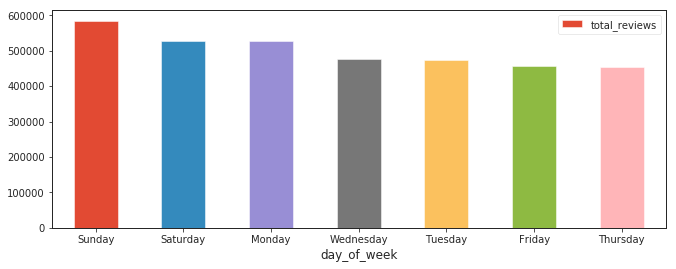

In [59]:
obw = spark.sql('''select 
  count(review_id) as total_reviews, 
  (case 
     when dow_number = '1' then 'Monday'
     when dow_number = '2' then 'Tuesday'
     when dow_number = '3' then 'Wednesday'
     when dow_number = '4' then 'Thursday'
     when dow_number = '5' then 'Friday'
     when dow_number = '6' then 'Saturday' 
     when dow_number = '7' then 'Sunday'
   end) as day_of_week 
  from yelp  
 group by dow_number
 order by total_reviews desc''')

obw = obw.toPandas().dropna()
obw.plot(y='total_reviews' , x ='day_of_week', kind='bar', figsize=(11,4), rot=0)

In [60]:
# number of reviews per restaurant
df.groupBy('Restaurant_name', 'city', 'state').count().sort('count').orderBy(['count'], ascending=[0]).show(5)

+------------------+---------+-----+-----+
|   Restaurant_name|     city|state|count|
+------------------+---------+-----+-----+
|Hash House A Go Go|Las Vegas|   NV|10745|
|      Mon Ami Gabi|Las Vegas|   NV| 8570|
|  Bacchanal Buffet|Las Vegas|   NV| 8568|
|      Wicked Spoon|Las Vegas|   NV| 6887|
|  Earl of Sandwich|Las Vegas|   NV| 5744|
+------------------+---------+-----+-----+
only showing top 5 rows



LA seems to be the city with larger number of restaurants as well as the place recieving more stars per restaurant.

In [61]:
# start rating distribution
state_df = df.groupBy('state', 'stars').count().orderBy('count').toPandas()
state_df['stars'] = state_df.stars.astype(int)
state_df.head()

state  stars  count
0    AR      2      1
1    BC      2      1
2    AR      5      1
3   XWY      3      1
4    WA      1      1

In [62]:
top_restaurant = state_df.sort_values(by=['count'], ascending = False).head(35)
top_restaurant = top_restaurant.pivot(index = 'state', columns = 'stars', values = 'count')
top_restaurant.head(5)
top_restaurant = top_restaurant.dropna()

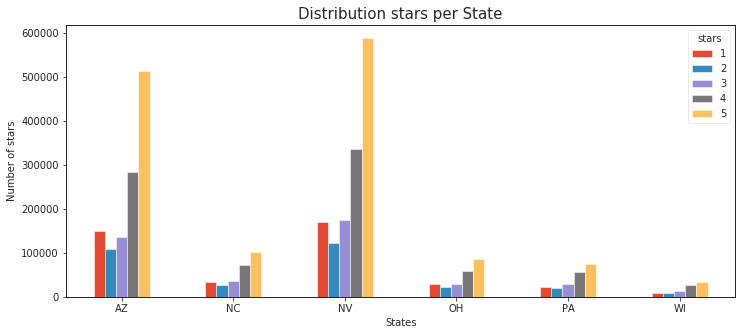

In [63]:
top_restaurant.plot.bar(figsize=(12,5))
plt.ylabel("Number of stars", fontsize = 10)
plt.xlabel("States", fontsize = 10)
plt.title("Distribution stars per State", fontsize = 15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xticks(rotation = 0)
plt.show()

**Distribution of stars per State**   
Nevada (NV) is the state that recieved the highest number of 5 stars followed by Arizona (AZ). These numbers are quite aligned with the porportion of restaurants per state as we saw it previously.

In [64]:
cal_len = udf(lambda x:len(x.split()))

In [65]:
df_1=df.select('stars',cal_len('text'))
df_1 = df_1.withColumnRenamed('<lambda>(text)', 'text_length')

In [66]:
df_1 = df_1.toPandas()

In [67]:
df_1.dtypes
df_1=df_1.astype('int32')

/software/Anaconda3-5.1.0-hadoop/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1440x1440 with 0 Axes>

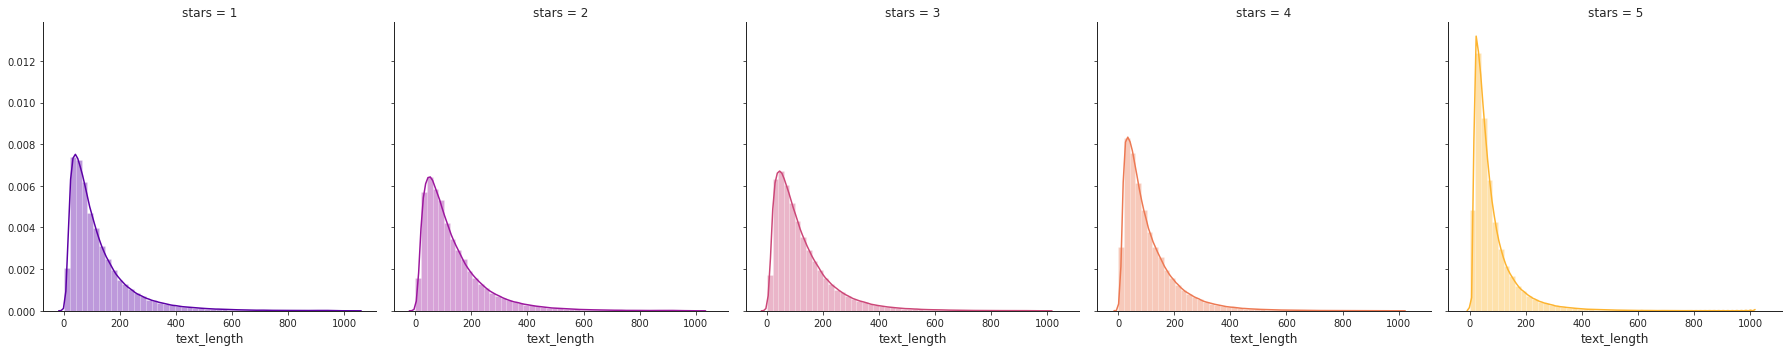

In [68]:
plt.figure(figsize = (20,20))
a = sns.FacetGrid(data =df_1, col = 'stars', hue = 'stars', palette='plasma', size=5)
a.map(sns.distplot, "text_length")
plt.show()

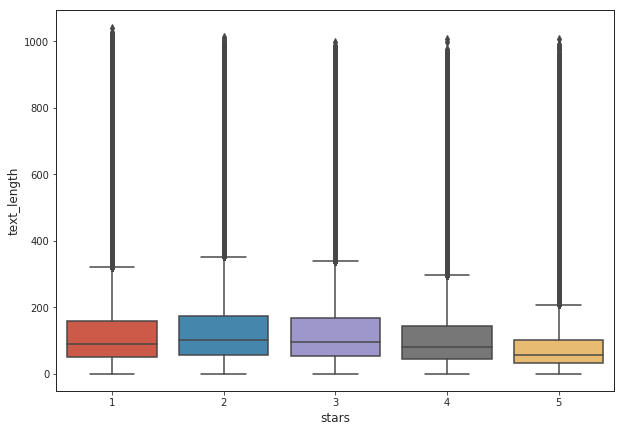

In [69]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'stars', y = 'text_length', data =df_1)

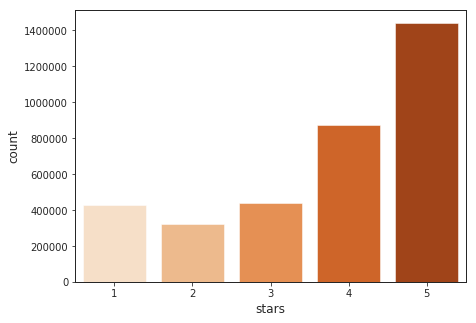

In [70]:
plt.figure(figsize = (7,5))
sns.countplot('stars', data = df_1, palette="Oranges")

In [71]:
# start rating distribution
stars_df = df.groupBy('stars', 'Restaurant_name').count().orderBy('count').toPandas()
stars_df['stars'] = stars_df.stars.astype(int)
stars_df.head()


stars        Restaurant_name  count
0      1      LeVilla Chophouse      1
1      3  Bad Tom Smith Brewing      1
2      1          Eureka! Grill      1
3      4         Blazing Bistro      1
4      2      Silver Star Meats      1

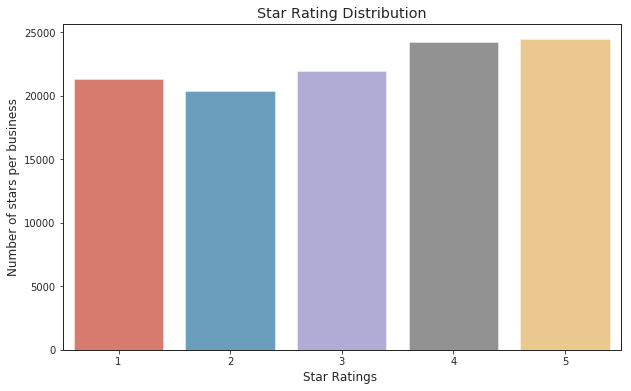

In [72]:
x = stars_df['stars'].value_counts()
x = x.sort_index()
 
#plot
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
sns.set_style('white')
plt.title("Star Rating Distribution")
plt.ylabel('Number of stars per business', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)
plt.show()

According to this graph, we can see people tend to rate restaurants if they are good. Here the number of given 5 stars is quite significant in terms of the 1 star or 2 stars.

In [73]:
top_restaurant = stars_df[stars_df['stars']==5].sort_values(by=['count'], ascending = False).head(10)
top_restaurant = top_restaurant.pivot(index = 'Restaurant_name', columns = 'stars', values = 'count')
top_restaurant.head(5)


stars                   5
Restaurant_name          
Bacchanal Buffet     3399
Earl of Sandwich     2875
Egg Works            3199
Grimaldi's Pizzeria  2636
Hash House A Go Go   4411

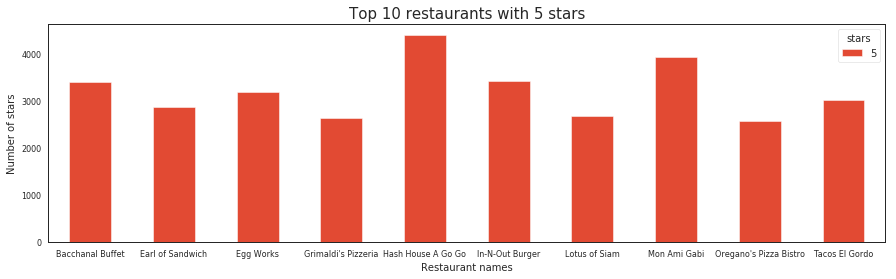

In [74]:
top_restaurant.plot.bar(figsize=(15,4))
plt.ylabel("Number of stars", fontsize = 10)
plt.xlabel("Restaurant names", fontsize = 10)
plt.title("Top 10 restaurants with 5 stars", fontsize = 15)
plt.xticks(size = 8)
plt.yticks(size = 8)
plt.xticks(rotation=0)
plt.show()


In [75]:
top_restaurant = stars_df[stars_df['stars']==5].sort_values(by=['count'], 
                                                            ascending = False).head(15)


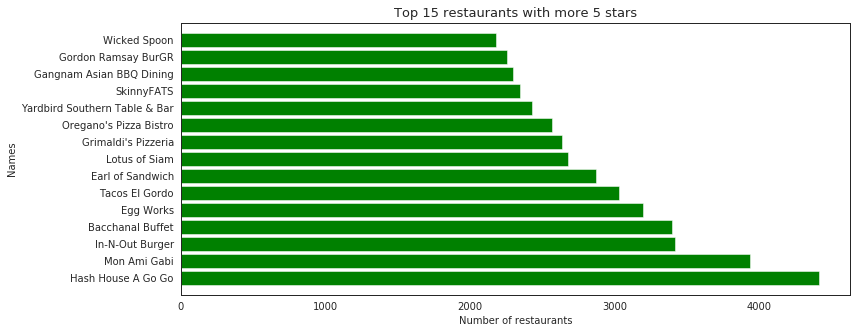

In [76]:
plt.figure(figsize=(12,5))
plt.barh(top_restaurant.Restaurant_name, top_restaurant['count'],
        color= 'g')
plt.title("Top 15 restaurants with more 5 stars", fontsize=13)
plt.xlabel("Number of restaurants", fontsize = 10)
plt.ylabel("Names", fontsize = 10)

plt.ylim((-1,15))
plt.show()

We can see Hash House A Go Go, Mon Ami Gabi and In-N-Out Burger are the restaurants that recieved the highest number of 5 stars.

In [77]:
stars_df = df.groupBy('stars', 'Restaurant_name').count().orderBy('count').toPandas()

top_restaurant = stars_df[stars_df['stars']==5].sort_values(by=['count'], ascending = False).head(10)
top_restaurant.head()

stars     Restaurant_name  count
112205      5  Hash House A Go Go   4411
112204      5        Mon Ami Gabi   3935
112202      5     In-N-Out Burger   3419
112201      5    Bacchanal Buffet   3399
112200      5           Egg Works   3199

In [78]:
top_1 = df.filter(df.Restaurant_name == 'Hash House A Go Go').groupBy('year').count().orderBy('count').toPandas()
top_2 = df.filter(df.Restaurant_name == 'Mon Ami Gabi').groupBy('year').count().orderBy('count').toPandas()
top_3 = df.filter(df.Restaurant_name == 'In-N-Out Burger').groupBy('year').count().orderBy('count').toPandas()

In [79]:
top_2 = top_2.dropna()
top_2['year'] = top_2['year'].astype(int)


Text(0.5,1,'In-N-Out Burger')

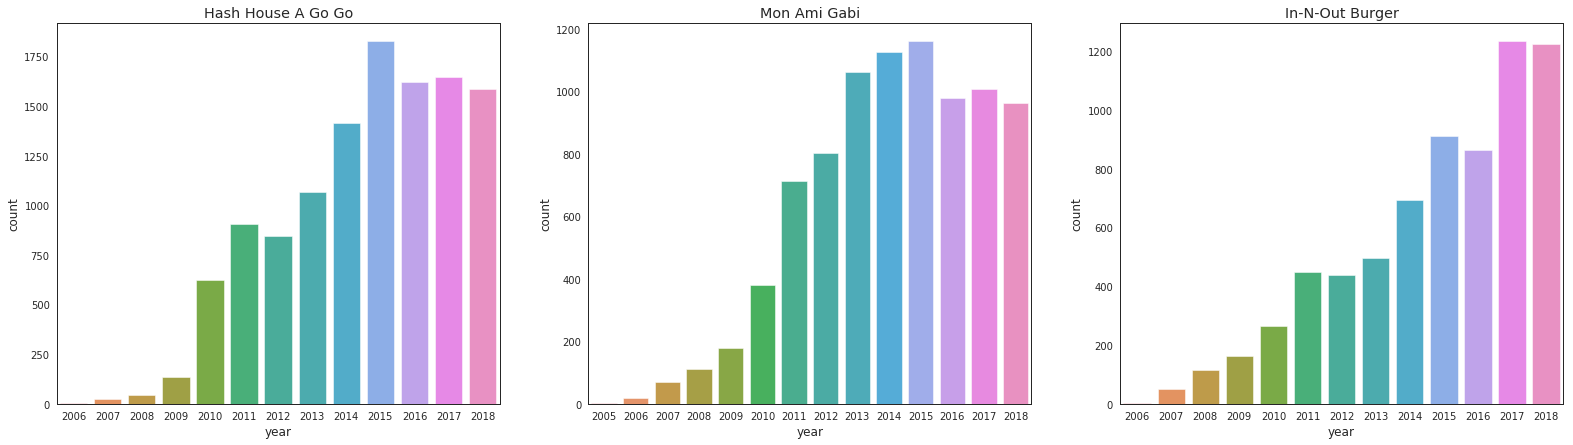

In [80]:
plt.figure(figsize=(27,7))

plt.subplot(1,3,1)
sns.barplot(x="year", y="count", data=top_1).set_title('Hash House A Go Go')

plt.subplot(1,3,2)
sns.barplot(x="year", y="count", data=top_2).set_title('Mon Ami Gabi')

plt.subplot(1,3,3)
sns.barplot(x="year", y="count", data=top_3).set_title('In-N-Out Burger')


When we look at the top 3 restaurants that recieve the most number of 5 stars, In-N-Out Burger seems to be increasing its number overall while Mon Ami Gabi and Hash House A Go Go seem to be performing less well in 2016, 2017 and 2018.

In [81]:
top_restaurant = stars_df[stars_df['stars']==1].sort_values(by=['count'], 
                                                            ascending = False).head(15)


In [82]:
top_restaurant.head()

stars         Restaurant_name  count
112206      1              McDonald's   7961
112193      1               Pizza Hut   2521
112192      1  Chipotle Mexican Grill   2506
112190      1                 Denny's   2384
112189      1      Buffalo Wild Wings   2372

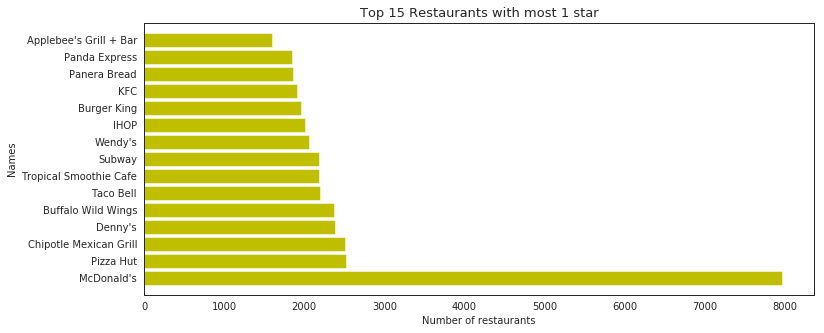

In [83]:
plt.figure(figsize=(12,5))
plt.barh(top_restaurant.Restaurant_name, top_restaurant['count'],
        color = 'y')
plt.title("Top 15 Restaurants with most 1 star", fontsize=13)
plt.xlabel("Number of restaurants", fontsize = 10)
plt.ylabel("Names", fontsize = 10)
plt.ylim((-1,15))
plt.show()

In [84]:
star_2 = df.filter('stars <=2')
star_2.select('Restaurant_name', 'city', 'categories').show()
star_2 = star_2.select('Restaurant_name', 'city', 'categories').groupBy('Restaurant_name').count().sort('count', ascending = False).toPandas()

+--------------------+-----------------+--------------------+
|     Restaurant_name|             city|          categories|
+--------------------+-----------------+--------------------+
|Capo's Italian Cu...|        Las Vegas|Restaurants, Italian|
|      Buffet At Asia|        Las Vegas|Seafood, Chinese,...|
|          RM Seafood|        Las Vegas|Restaurants, Sush...|
|       Auntie Anne's|        Las Vegas|Food, Restaurants...|
|La Madeleine Coun...|          Phoenix|Food, Cafes, Bake...|
|         Metro Pizza|        Las Vegas|  Restaurants, Pizza|
|El Patron Mexican...|          Chardon|Restaurants, Mexican|
|           FireWater|        Charlotte|American (New), R...|
|Pancheros Mexican...|            Tempe|Restaurants, Mexican|
|Zablong Peculiar ...|        Charlotte|Pizza, Local Flav...|
|         Tropicalyyc|          Calgary|Nightlife, Restau...|
|      Blanco Cantina|          Calgary|Tex-Mex, Pubs, Be...|
|        Fusion Sushi|          Calgary|Sushi Bars, Japan...|
|      L

When we look at the restaurants with more stars =1, McDonald's is by far number one on the list followed by Pizza Hut and Chipotle Mecan Grill (all fast food chains). In terms of categories with the most number of rating between (1 star and 2 stars), mexican places are the most frenquent.

In [85]:
reviews = df.groupBy('state', 'stars').count().orderBy(['count'], ascending=[0])
reviews = reviews.toPandas()

In [86]:
reviews = reviews.pivot(index = 'state', columns = 'stars', values = 'count')
reviews= reviews.dropna()

In [87]:
labels = np.array(['AB', 'AZ', 'IL', 'NC', 'NM', 'NV', 'NY', 'OH', 'PA', 'QC', 'SC', 'TX',
       'WI'])

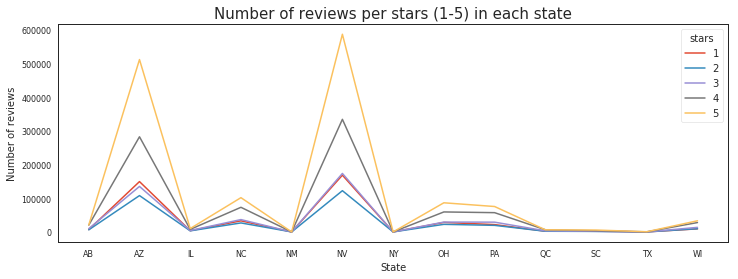

In [88]:
ax = reviews.plot(figsize=(12,4))
plt.ylabel("Number of reviews", fontsize = 10)
plt.xlabel("State", fontsize = 10)
plt.title("Number of reviews per stars (1-5) in each state", fontsize = 15)
plt.xticks(size = 8)
plt.yticks(size = 8)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.show()


Once again, when we look at the number of reviews and number of stars, NV and AZ master in 5 stars. However, we can also see an important number of 1 stars in these states.

In [89]:
compliment = df.groupBy('Restaurant_name','compliment_cool').count().groupBy('Restaurant_name','compliment_cool').agg({'count':'avg'}).sort(desc('avg(count)')).toPandas()

In [90]:
compliment = compliment.sort_values(['compliment_cool'], ascending=[False]).head(10)
compliment.head()

Restaurant_name  compliment_cool  avg(count)
458432          Swensons Drive-In            32266         1.0
203078                Maiku Sushi            32266         1.0
247626  Gaucho Parrilla Argentina            32266         1.0
379694           Bacchanal Buffet            23134         1.0
451443        Inna Gadda di Pizza            23134         1.0

In [91]:
compliment = compliment.set_index('Restaurant_name')

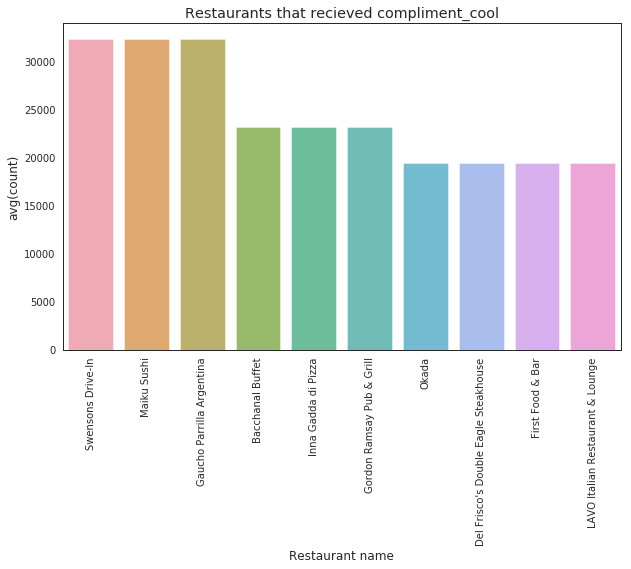

In [92]:
x = compliment['compliment_cool']
#plot
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Restaurants that recieved compliment_cool")
plt.ylabel('avg(count)', fontsize=12)
plt.xlabel('Restaurant name', fontsize=12)
plt.xticks(rotation=90)
plt.show()

When we look at restaurants that recieved the compliment cool, we see different names. In particular: Gaucho Parrilla Argentina, Swensons Drive-in and Maiku Sushi with the highest number of compliment_cool. 

In [93]:
review_trend = df.groupBy('Restaurant_name', 'funny', 'cool', 'fans').count().groupBy('Restaurant_name').agg({'count':'avg'}).sort(desc('avg(count)')).toPandas()

In [94]:
review_trend.head()

Restaurant_name  avg(count)
0       Jimmy V's Subs and wings    6.000000
1                     Sushi Haru    5.000000
2  Kwality Indian Tiffin Service    4.500000
3                     McDonald's    4.113369
4          Lemme Eat Gluten Free    4.000000

Surprisely, when we look at restaurants that have recieved a combination of cool, fans and funny tags, McDonald's shows up on the list. Something quite different from all the previous negative reviews/ number of stars.

#### 1.3.3 User

In [95]:
df_user = df.groupBy('user_id').count().sort(desc('count')).toPandas()
df_user.head(5)


user_id  count
0  bLbSNkLggFnqwNNzzq-Ijw   1523
1  ELcQDlf69kb-ihJfxZyL0A   1378
2  d_TBs6J3twMy9GChqUEXkg   1066
3  DK57YibC5ShBmqQl97CKog   1059
4  PKEzKWv_FktMm2mGPjwd0Q   1035

In [96]:
df_user = df.groupBy('user_name').count().sort(desc('count')).toPandas()
df_user.head(5)


user_name  count
0   Michael  31864
1      John  31646
2     David  29959
3     Chris  28830
4      Mike  28659

In [97]:
df_user = df.groupBy('user_name', 'user_id').count().sort(desc('count')).toPandas()
df_user = df_user.head(10)


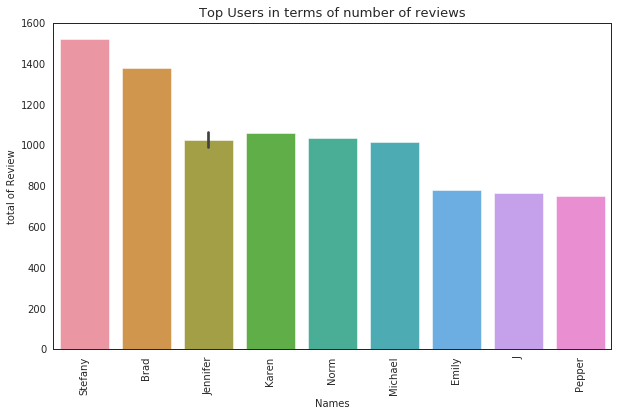

In [98]:
plt.figure(figsize=(10,6))
sns.barplot(x='user_name', y='count', data=df_user)
plt.title("Top Users in terms of number of reviews", fontsize=13)
plt.xlabel("Names", fontsize = 10)
plt.ylabel("total of Review", fontsize = 10)
plt.xticks(rotation=90)
plt.show()

In [99]:
df_user = df.groupBy('user_name', 'city', 'user_id').count().sort(desc('count')).toPandas()

In [100]:
df_user.head(15)

user_name        city                 user_id  count
0    Stefany   Las Vegas  bLbSNkLggFnqwNNzzq-Ijw   1369
1       Norm   Las Vegas  PKEzKWv_FktMm2mGPjwd0Q    974
2    Michael   Las Vegas  U4INQZOPSUaj8hMjLlZ3KA    774
3      Emily   Las Vegas  UYcmGbelzRa0Q6JqzLoguw    717
4       Jade   Las Vegas  n86B7IkbU20AkxlFX_5aew    639
5     Darren  Pittsburgh  rCWrxuRC8_pfagpchtHp6A    603
6     Nelson   Las Vegas  3nDUQBjKyVor5wV0reJChg    595
7       Brad  Scottsdale  ELcQDlf69kb-ihJfxZyL0A    586
8   Jennifer     Phoenix  d_TBs6J3twMy9GChqUEXkg    564
9     Westie   Las Vegas  L8P5OWO1Jh4B2HLa1Fnbng    553
10     Clint   Las Vegas  C2C0GPKvzWWnP57Os9eQ0w    548
11     Misti   Las Vegas  qewG3X2O4X6JKskxyyqFwQ    514
12  Jennifer     Phoenix  cMEtAiW60I5wE_vLfTxoJQ    488
13    Philip   Las Vegas  8DEyKVyplnOcSKx39vatbg    485
14     Bruce   Charlotte  hWDybu_KvYLSdEFzGrniTw    472

The name of the user that has summitted more reviews is Stefany with more than 1000 reviews. Most of the top users are from LA, as we could expected, as well as from Phoenix and Charlotte. 

In [101]:
#attributes and hours not used
# I noticed there were Canadian restaurants in the dataset - I thought this was only USA data.
# we might need to review the categories pie chart
# I converted the dataset to Pandas for the types of cuisine. We may also have to change this.

**world cloud visulization**

In [65]:
def convert_rating(rating):
    if rating >=4:
        return 1
    else:
        return 0

In [66]:
punct_remover = udf(lambda x: lower_clean_str(x))

In [67]:
#remove punctuations
def lower_clean_str(x):
    punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    lowercased_str = x.lower()
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str

In [68]:
#remove punctuation and lower 
df_word = df.select('*', punct_remover('text')).drop('text')
df_word = df_word.withColumnRenamed('<lambda>(text)', 'text')

In [69]:
rating_convert = udf(lambda x: convert_rating(x))

In [78]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
#!pip install wordcloud

In [73]:
word_visual =df_word.select('text').limit(2000000).toPandas()

In [74]:
word_visual.head()

text
0  they ran out of cobbler  gee dang it that cobb...
1  swung by this place while i was up in madison ...
2  great local pub the happy hour is on point 194...
3  i came in today parched my server tannie immed...
4  what an amazing restaurant with amazing staff ...

In [75]:
text = " ".join(review for review in word_visual.text)

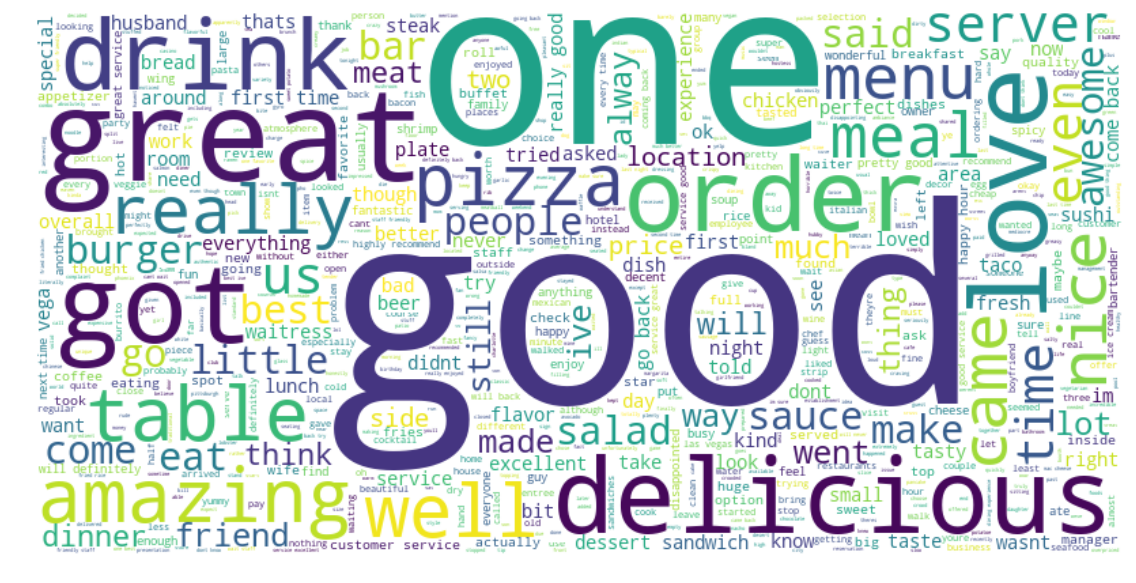

In [79]:
# Start with one review:
#text = negative.select('text').limit(1).collect()
#text=text[0].text
# Create and generate a word cloud image:
plt.figure(figsize = (20,10))
stopwords = set(STOPWORDS)
stopwords.update(["place", "food", "ordered","restaurant"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=1000,width=800, height=400).generate(text[:10000000])
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# NLP--Sentiment Analysis on Review dataset

In [80]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer,StringIndexer,CountVectorizer
import pyspark.mllib.classification
from pyspark.sql.functions import udf
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
import string
import re

In [81]:
import nltk

In [82]:
df_NLP =df_word.select('*',rating_convert('stars'))
df_NLP = df_NLP.withColumnRenamed('<lambda>(stars)', 'isPositive')

In [83]:
#tokenize words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Build the pipeline 
pipeline = Pipeline(stages=[tokenizer,remover])
# Fit the pipeline 
df_NLP = pipeline.fit(df_NLP).transform(df_NLP)

### 1. Hashing TF

#### 1.1 Text Preprocessing

In [ ]:
# #Maps a sequence of terms to their term frequencies using the hashing trick. 
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
# Build the pipeline 
pipeline = Pipeline(stages=[hashingTF,idf])
# Fit the pipeline 
encodedData_hasingTF = pipeline.fit(df_NLP).transform(df_NLP)

In [ ]:
#drop the redundant source column
#columns_to_drop = ['business_id','date','review_id','words','text']
encodedData_tf = encodedData_hasingTF.select('review_id','words','features','stars')

In [ ]:
encodedData_tf.select('review_id','words','features','stars').limit(5).toPandas()

review_id                                              words  \
0  a0r23pA6D4HDLb9P5gmQkA  [they, ran, out, of, cobbler, , gee, dang, it,...   
1  TbU3S2kWmfajlVov3I9EKw  [swung, by, this, place, while, i, was, up, in...   
2  y0BLDiU8nQi22t9OF2TEsg  [great, local, pub, the, happy, hour, is, on, ...   
3  08j8zUlyJylKcJa_rIeB-w  [i, came, in, today, parched, my, server, tann...   
4  E5brqk7xXfvriiekHvI9WA  [what, an, amazing, restaurant, with, amazing,...   

                                            features  stars  
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      4  
1  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      4  
2  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      5  
3  (0.0, 1.8615897599805193, 0.0, 0.0, 0.0, 0.0, ...      5  
4  (0.0, 1.8615897599805193, 0.0, 0.0, 0.0, 0.0, ...      5

In [ ]:
encodedData_tf.groupby('stars').count().show()

+-----+-------+
|stars|  count|
+-----+-------+
|    1| 425541|
|    3| 436648|
|    5|1440619|
|    4| 873188|
|    2| 321753|
+-----+-------+



In [ ]:
DF_sa =encodedData_tf.select(rating_convert('stars'),'features')
DF_sa = DF_sa.withColumnRenamed('<lambda>(stars)', 'isPositive')

In [ ]:
DF_sa.show(3)

+----------+--------------------+
|isPositive|            features|
+----------+--------------------+
|         1|(1000,[40,168,356...|
|         1|(1000,[28,55,124,...|
|         1|(1000,[13,37,141,...|
+----------+--------------------+
only showing top 3 rows



In [ ]:
DF_sa.select('isPositive').distinct().show()

+----------+
|isPositive|
+----------+
|         0|
|         1|
+----------+



In [ ]:
#convert classification from string to integer to enable model to run
from pyspark.sql import types 
DF_sa = DF_sa.withColumn("isPositive",DF_sa["isPositive"].cast('int'))

In [ ]:
DF_sa.groupby('isPositive').count().show()

+----------+-------+
|isPositive|  count|
+----------+-------+
|         1|2313807|
|         0|1183942|
+----------+-------+



In [ ]:
dataset_size=float(DF_sa.select("isPositive").count())
numPositives=DF_sa.select("isPositive").where('isPositive == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 2313807
Percentage of ones are 66.1513161751


#### 1.2 Modeling

split data into train and test with 80% and 20%

In [94]:
splits = DF_sa.randomSplit([0.8, 0.2],seed=100)
train_df_tf = splits[0]
test_df_tf = splits[1]

#### Logistic Regression classification

In [95]:
from pyspark.ml.classification import LogisticRegression

# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_tf = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='isPositive')

# Fit the model to the data.
lgModel_tf = lg_tf.fit(train_df_tf)

# Given a dataset, predict each point's label, and show the results.
lg_pred_tf = lgModel_tf.transform(test_df_tf)

In [96]:
lg_pred_tf.show(5)

+----------+--------------------+--------------------+--------------------+----------+
|isPositive|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|         0|(1000,[0,1,2,17,2...|[-0.6174669974931...|[0.35035776228069...|       1.0|
|         0|(1000,[0,1,3,5,7,...|[4.50902213486586...|[0.98911066266847...|       0.0|
|         0|(1000,[0,1,3,7,12...|[16.5565108797684...|[0.99999993549421...|       0.0|
|         0|(1000,[0,1,3,7,13...|[4.95385156119835...|[0.99299326158382...|       0.0|
|         0|(1000,[0,1,3,26,3...|[2.51457376416847...|[0.92515720062340...|       0.0|
+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [97]:
trainingSummary = lgModel_tf.summary

areaUnderROC: 0.905062936697


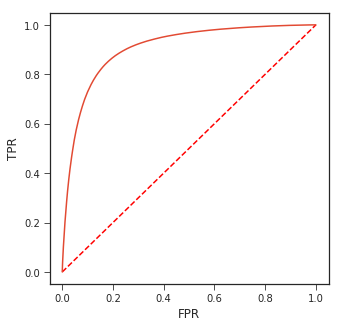

In [98]:
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
#import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lgModel_tf.summary.roc.select('FPR').collect(),
         lgModel_tf.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [99]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="isPositive", predictionCol="prediction")

print(evaluator.evaluate(lg_pred_tf, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(lg_pred_tf, {evaluator.metricName: "f1"}))

0.845916933931
0.841786976921


In [100]:
#create confusion matrix function to plot
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
class_temp = lg_pred_tf.select("isPositive").groupBy("isPositive")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["isPositive"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

['1', '0']

In [102]:
from sklearn.metrics import confusion_matrix
y_true = lg_pred_tf.select("isPositive").toPandas()
y_pred = lg_pred_tf.select("prediction").toPandas()

In [103]:
y_true = y_true.astype('str')
y_pred = y_pred.astype('int')
y_pred = y_pred.astype('str')

In [104]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[429649,  33006],
       [ 74707, 161696]])

Normalized confusion matrix
[[0.92865958 0.07134042]
 [0.31601545 0.68398455]]


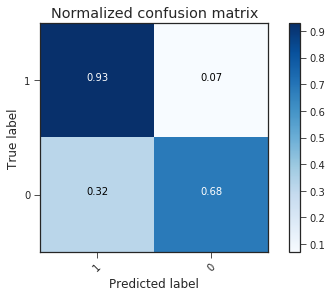

In [105]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt_tf = DecisionTreeClassifier(featuresCol = "features", labelCol='isPositive', maxDepth = 10)
# Fit the model to the data.
dtModel_tf = dt_tf.fit(train_df_tf)
dt_pred_tf = dtModel_tf.transform(test_df_tf)

In [ ]:
dt_pred_tf.show(5)

+----------+--------------------+---------------+--------------------+----------+
|isPositive|            features|  rawPrediction|         probability|prediction|
+----------+--------------------+---------------+--------------------+----------+
|         0|(1000,[0,1,2,17,2...|[3260.0,7137.0]|[0.31355198614985...|       1.0|
|         0|(1000,[0,1,3,5,7,...|   [140.0,17.0]|[0.89171974522293...|       0.0|
|         0|(1000,[0,1,3,7,12...|   [287.0,97.0]|[0.74739583333333...|       0.0|
|         0|(1000,[0,1,3,7,13...|  [388.0,365.0]|[0.51527224435590...|       0.0|
|         0|(1000,[0,1,3,26,3...|  [447.0,565.0]|[0.44169960474308...|       1.0|
+----------+--------------------+---------------+--------------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="isPositive", predictionCol="prediction")

print(evaluator.evaluate(dt_pred_tf, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(dt_pred_tf, {evaluator.metricName: "f1"}))

0.741254659842
0.743895047915


#### Gradient boost classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt_tf = GBTClassifier(maxIter=10,featuresCol = 'features', labelCol='isPositive')
gbtModel_tf = gbt_tf.fit(train_df_tf)
gbt_pred_tf = gbtModel_tf.transform(test_df_tf)
gbt_pred_tf.show(5)

+----------+--------------------+--------------------+--------------------+----------+
|isPositive|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|         0|(1000,[0,1,2,17,2...|[-0.4417089651540...|[0.29247000079210...|       1.0|
|         0|(1000,[0,1,3,5,7,...|[0.33475554823389...|[0.66139367688046...|       0.0|
|         0|(1000,[0,1,3,7,12...|[0.95611611216368...|[0.87126971900478...|       0.0|
|         0|(1000,[0,1,3,7,13...|[2.84992998375479...|[0.50014249649532...|       0.0|
|         0|(1000,[0,1,3,26,3...|[0.14361673622902...|[0.57131870668708...|       0.0|
+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="isPositive", predictionCol="prediction")

print(evaluator.evaluate(gbt_pred_tf, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(gbt_pred_tf, {evaluator.metricName: "f1"}))

0.767840436702
0.750678881807


Using hasingTF with keep 1000 features, the highest accuarcy is only 83% using logistic classification model

### 2.1 Count vectorizer--Pipline & dataset

In [ ]:
#takes longer time to transform
cv = CountVectorizer(inputCol='filtered', outputCol='rawFeatures')
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build the pipeline 
pipeline_cv = Pipeline(stages=[cv,idf])

# Fit the pipeline, count vectorizer
encodedData_cv = pipeline_cv.fit(df_NLP).transform(df_NLP)

In [ ]:
encodedData_cv_model = encodedData_cv.select('review_id','words','rawfeatures','features','stars','text','isPositive')

In [ ]:
#model_cv= model_cv.filter(model_cv.isPositive != 99)
encodedData_cv_model = encodedData_cv_model.withColumn("isPositive",encodedData_cv_model["isPositive"].cast('int'))

In [ ]:
encodedData_cv_model.show(3)

+--------------------+--------------------+--------------------+--------------------+-----+--------------------+----------+
|           review_id|               words|         rawfeatures|            features|stars|                text|isPositive|
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+----------+
|a0r23pA6D4HDLb9P5...|[they, ran, out, ...|(262144,[0,2,237,...|(262144,[0,2,237,...|    4|they ran out of c...|         1|
|TbU3S2kWmfajlVov3...|[swung, by, this,...|(262144,[0,3,7,12...|(262144,[0,3,7,12...|    4|swung by this pla...|         1|
|y0BLDiU8nQi22t9OF...|[great, local, pu...|(262144,[2,3,4,12...|(262144,[2,3,4,12...|    5|great local pub t...|         1|
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+----------+
only showing top 3 rows



#### 2.2 Modeling

In [ ]:
#split data into train and test
splits = encodedData_cv_model.randomSplit([0.8, 0.2],seed=100)
train_df = splits[0]
test_df = splits[1]

#train_df.show(1)

#### logistic Regression classification

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lr  = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='isPositive')

# Fit the model to the data.
lrModel = lr.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
lr_pred = lrModel.transform(test_df)

In [ ]:
lr_pred.show(5)

+--------------------+--------------------+--------------------+--------------------+-----+--------------------+----------+--------------------+--------------------+----------+
|           review_id|               words|         rawfeatures|            features|stars|                text|isPositive|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+----------+--------------------+--------------------+----------+
|--Y3QrnTjXvOP93SA...|[i, went, there, ...|(262144,[1,4,20,3...|(262144,[1,4,20,3...|    5|i went there for ...|         1|[-2.3306236138012...|[0.08861828411099...|       1.0|
|--swdG-nZ6L_31dYn...|[great, food, but...|(262144,[1,2,4,5,...|(262144,[1,2,4,5,...|    5|great food but a ...|         1|[-2.0150130815396...|[0.11763563428728...|       1.0|
|-0FZr21_UsODY6Bla...|[bryan, the, bart...|(262144,[0,20,39,...|(262144,[0,20,39,...|    5|bryan the bartend...|   

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="isPositive", predictionCol="prediction")

print(evaluator.evaluate(lr_pred, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(lr_pred, {evaluator.metricName: "f1"}))

0.898310297572
0.897148127605


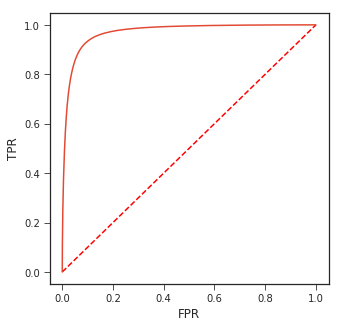

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
class_temp = lr_pred.select("isPositive").groupBy("isPositive")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["isPositive"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

['1', '0']

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = lr_pred.select("isPositive").toPandas()

In [ ]:
y_pred = lr_pred.select("prediction").toPandas()


In [ ]:
y_true = y_true.astype('str')
y_pred = y_pred.astype('int')
y_pred = y_pred.astype('str')

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[437618,  25663],
       [ 45424, 190353]])

Normalized confusion matrix
[[0.94460597 0.05539403]
 [0.19265662 0.80734338]]


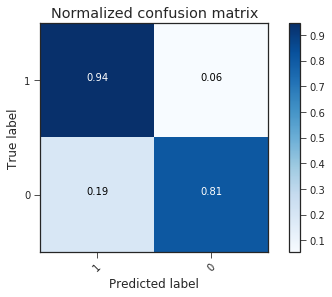

In [ ]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Decision Tree----run ouf of memory

In [126]:
# from pyspark.ml.classification import DecisionTreeClassifier
# dt = DecisionTreeClassifier(featuresCol = "features", labelCol='isPositive',maxDepth = 3)
# # Fit the model to the data. , maxDepth = 10
# dtModel = dt.fit(train_df)
# dt_pred = dtModel.transform(test_df)

In [127]:
# dt_pred.show(5)

In [128]:
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# #print evaluation metrics
# evaluator = BinaryClassificationEvaluator(labelCol="isPositive")

# print(evaluator.evaluate(dt_pred, {evaluator.metricName: "accuracy"}))
# print(evaluator.evaluate(dt_pred, {evaluator.metricName: "f1"}))

#### Gradient boost classifier--still cannot run now

In [129]:
# from pyspark.ml.classification import GBTClassifier
# gbt = GBTClassifier(maxIter=10,featuresCol = 'rawfeatures', labelCol='isPositive')
# gbtModel = gbt.fit(train_df)
# gbt_pred = gbtModel.transform(test_df)
# gbt_pred.show(5)

In [130]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# #print evaluation metrics
# evaluator = MulticlassClassificationEvaluator(labelCol="isPositive", predictionCol="prediction")

# print(evaluator.evaluate(gbt_pred, {evaluator.metricName: "accuracy"}))
# print(evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"}))

#### 2.3 Plot wordcloud results

In [131]:
df_visualize_positive = test_df.filter(test_df.isPositive==1).select('words').toPandas()

In [132]:
df_visualize_positive=df_visualize_positive['words'].apply(' '.join)

In [133]:
df_visualize_positive.head()

0    i went there for my daughters birthday the foo...
1    great food but a little pricey meat is excelle...
2    bryan the bartender is worth going to zuma he ...
3    its pretty good bbq smell fills the air but th...
4    have ordered from this place a few times livin...
Name: words, dtype: object

In [ ]:
text = " ".join(review for review in df_visualize_positive)

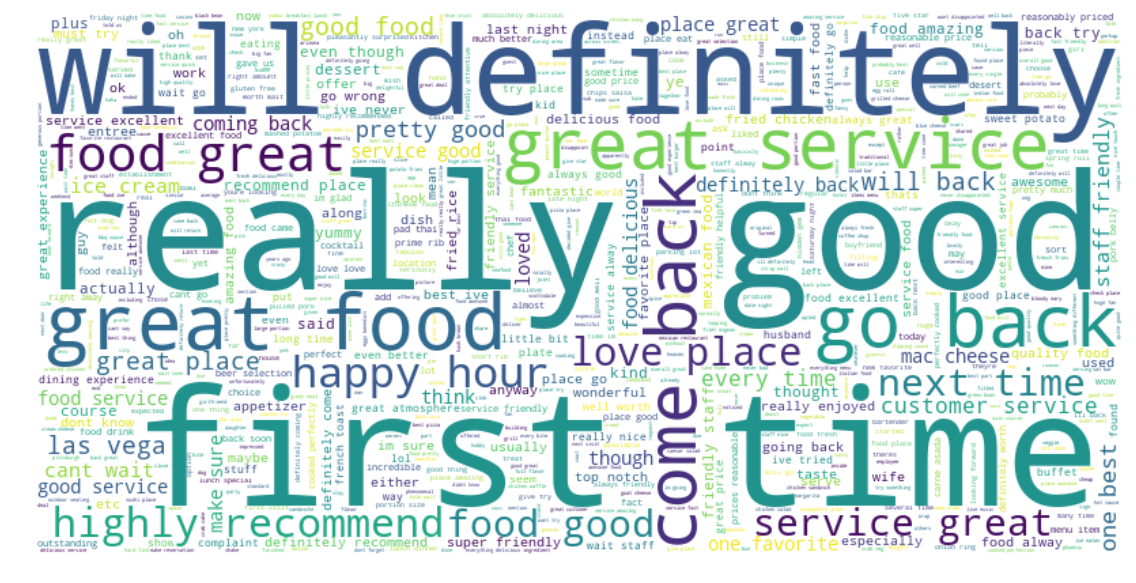

In [ ]:
plt.figure(figsize = (20,10))
stopwords = set(STOPWORDS)
#stopwords.update(["place", "food", "ordered","restaurant"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=1000,width=800, height=400).generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df_visualize_negative = test_df.filter(test_df.isPositive==0).select('words').toPandas()

In [ ]:
df_visualize_negative=df_visualize_negative['words'].apply(' '.join)

In [ ]:
text_negative = " ".join(review for review in df_visualize_negative)

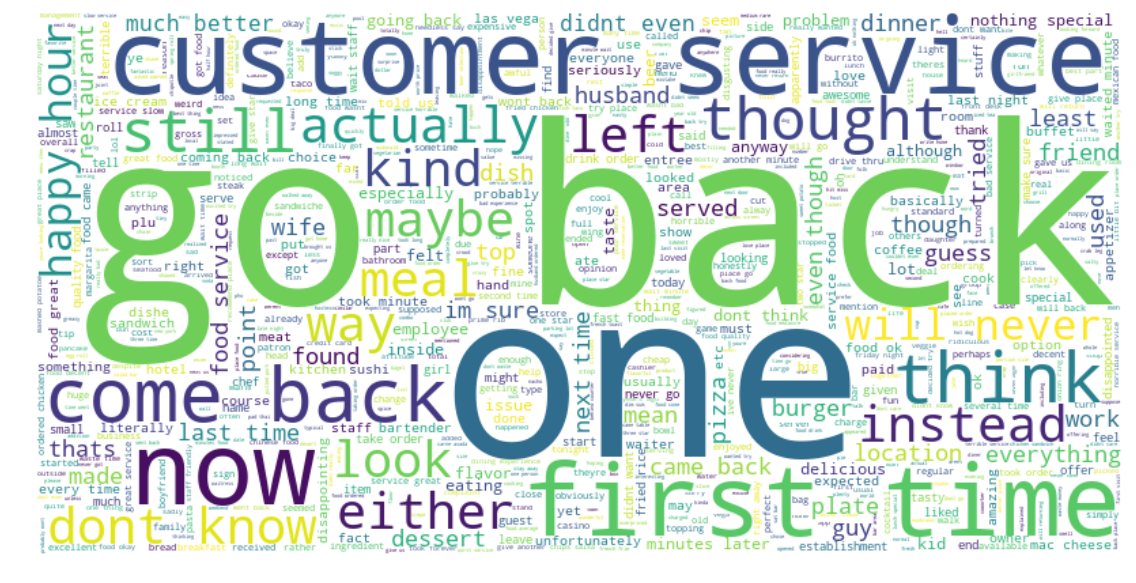

In [ ]:
plt.figure(figsize = (20,10))
stopwords = set(STOPWORDS)
stopwords.update(["good", "pretty","well"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=1000,width=800, height=400).generate(text_negative)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Yelp ALS Model and Association Mining

In [140]:
# linear regression to estimate rating.
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.sql import Window
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
# from pyspark.sql.functions import rowNumber

In [141]:
spark = SparkSession.builder.appName('yelpreviewdataset').getOrCreate()
# conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

In [142]:
df_business = spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_business.json")

In [143]:
#change name for starts to avoid duplicates
df_business=df_business.withColumnRenamed("stars", "Restaurant_stars")
df_business=df_business.withColumnRenamed("name", "Restaurant_name")
df_business=df_business.filter(psf.col('categories').rlike('Restaurants'))
df_business = df_business.select('*','attributes.*','hours.*')
columns_to_drop = ['address','postal_code','review_count','attributes','hours']
df_business = df_business.drop(*columns_to_drop)

In [144]:
df_business = df_business.withColumn('categories', regexp_replace(col("categories"), "(,?\ ?Restaurants,?)", ""))
df_business = df_business.withColumn('categories', regexp_replace(col("categories"), "( ?)", ""))

In [145]:
df_reviews =  spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_review.json")

In [146]:
columns_to_drop = ['cool','funny','average_stars']
df_reviews = df_reviews.drop(*columns_to_drop)

In [147]:
df_user =  spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_user.json")

In [148]:
columns_to_drop = ['elite','useful','yelping_since','review_count','average_stars']
df_user = df_user.drop(*columns_to_drop)
df_user=df_user.withColumnRenamed("name", "user_name")

#### before merge - add a column user_id_int / business_id_int to the frame

In [149]:
w = Window().orderBy('business_id')
df_business= df_business.withColumn("business_id_int", psf.row_number().over(w))
w = Window().orderBy('user_id')
df_user= df_user.withColumn("user_id_int", psf.row_number().over(w))

In [150]:
#join three tables into one table in case need for future
df = df_reviews.join(df_business,on ='business_id', how = 'inner')
df = df.join(df_user,on ='user_id', how = 'inner')

#### select data from top three cities - Toronto, ON; Las Vegas, NV; Phoenix, AZ

In [151]:
# df_tor = df.filter(psf.col('city')=='Toronto').filter(psf.col('state')=='ON')
df_las = df.filter(psf.col('city')=='Las Vegas').filter(psf.col('state')=='NV')
df_pho = df.filter(psf.col('city')=='Phoenix').filter(psf.col('state')=='AZ')
df_sco = df.filter(psf.col('city')=='Scottsdale').filter(psf.col('state')=='AZ')

### 1. Model - ALS

Alternating Least Squares(ALS) is a the model we’ll use to fit our data and find similarities. ALS is an iterative optimization process where we for every iteration try to arrive closer and closer to a factorized representation of our original data.

For implicit preference data, the algorithm used is based on “Collaborative Filtering for Implicit Feedback Datasets”,, adapted for the blocked approach used here.

Essentially instead of finding the low-rank approximations to the rating matrix R, this finds the approximations for a preference matrix P where the elements of P are 1 if r > 0 and 0 if r <= 0. The ratings then act as ‘confidence’ values related to strength of indicated user preferences rather than explicit ratings given to items.

In [152]:
from pyspark.ml.recommendation import ALS

### 1. Using Stars for Recommendation of the Top 3 Cities

#### - Las Vegas

In [153]:
ratings = df_las.select('user_id_int','business_id_int','Restaurant_name','user_name','stars')

In [154]:
train_df, test_df = ratings.randomSplit([.8,.2],seed=1)
als = ALS(maxIter=10, regParam=0.3, userCol="user_id_int", itemCol="business_id_int", ratingCol="stars",
          coldStartStrategy="drop", rank=10, nonnegative = True)
#fit and predict
model = als.fit(train_df)
predictions = model.transform(test_df)

In [155]:
predictions_df = predictions.toPandas()

In [156]:
predictions_df.head()

user_id_int  business_id_int Restaurant_name user_name  stars  prediction
0      1473928             3749           Go!ku    Justin    5.0    4.035408
1       964066             3749           Go!ku   Patrick    3.0    1.741017
2      1178738             3749           Go!ku     Aaron    1.0    2.289105
3       744494             3749           Go!ku     Mable    5.0    2.432937
4      1375593             3749           Go!ku      Jean    4.0    3.947778

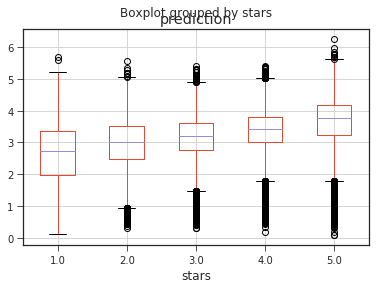

In [157]:
predictions_df.boxplot('prediction','stars')

In [158]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='stars')
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName='r2', labelCol='stars')
r2 = evaluator.evaluate(predictions)
print("r2 = " + str(r2))

Root-mean-square error = 1.37398324718
r2 = -0.0958141321246


In [159]:
# Generate top 10 restaurant recommendations for top 10 users
userRecs = model.recommendForAllUsers(10).limit(10)
userRecs_DF = (userRecs
  .select("user_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("user_id_int", "recommendation.*")
)
userRecs_DF2 = userRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','Restaurant_name'), on='business_id_int', how ='inner')
userRecs_df2 = userRecs_DF2.toPandas()

In [160]:
userRecs_df2.sort_values(['user_name','rating'],ascending=[True,False]).head(20)

business_id_int  user_id_int    rating user_name  \
19            20626         1591  5.622161     Allan   
18            50125         1591  5.527399     Allan   
17            25149         1591  5.459542     Allan   
16             3452         1591  5.419254     Allan   
15            44542         1591  5.258955     Allan   
14            23518         1591  5.238706     Allan   
13            36110         1591  5.221524     Allan   
12            36236         1591  5.192428     Allan   
11            48705         1591  5.190172     Allan   
10            32649         1591  5.175789     Allan   
39            20626         2659  5.515312  Carrillo   
38            14307         2659  5.404459  Carrillo   
37            16139         2659  5.369372  Carrillo   
36            18742         2659  5.365840  Carrillo   
35            10908         2659  5.335482  Carrillo   
34            31450         2659  5.291336  Carrillo   
33            29732         2659  5.288423  Carrillo   
32            43590         2659  5.260175  Carrillo   
31            54763         2659  5.259389  Carrillo   
30            47147         2659  5.258110  Carrillo   

                                      Restaurant_name  
19                                       Pretzel Time  
18                              El Cochinito Contento  
17                           Sahara Korean Restaurant  
16                                 Potato Valley Cafe  
15                          Roll Play Fusion Eggrolls  
14                       Arisra Thai Seafood & Steaks  
13                                             Subway  
12                                   Clamato's & Beer  
11                                       Meallionaire  
10  Tetsuro's Sayonara, Aloha, Going Away Uye At J...  
39                                       Pretzel Time  
38                                 Fernandez Hot-Dogs  
37                                  Dinner in the Sky  
36                                 B's Smokehouse Bbq  
35                        The Steakhouse at Treasures  
34                                         Pho Ha Noi  
33                                   Tower Suite Cafe  
32                       Lloyd George U.S. Courthouse  
31                                Mansion Dining Room  
30                               Roberta's Steakhouse

In [161]:
# Generate top 10 user recommendations for top 10 restaurant
restaurantRecs = model.recommendForAllItems(10).limit(10)
restaurantRecs_DF = (restaurantRecs
  .select("business_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("business_id_int", "recommendation.*")
)
restaurantRecs_DF2 = restaurantRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','Restaurant_name'), on='business_id_int', how ='inner')
restaurantRecs_df2 = restaurantRecs_DF2.toPandas()

In [162]:
restaurantRecs_df2.sort_values(['Restaurant_name','rating'],ascending=[True,False]).head(20)

business_id_int  user_id_int    rating user_name  \
63            35912      1084940  6.393089      Paul   
25            35912       427261  6.208717    Veonna   
51            35912       864678  5.890946     Aimee   
94            35912      1530586  5.890946      Paul   
59            35912      1036653  5.772056         B   
98            35912      1624877  5.682432      Greg   
21            35912       413833  5.627209    Durana   
47            35912       774390  5.627209    Dianey   
54            35912       911603  5.627209        Ed   
56            35912       940701  5.627209     Kelly   
64            13832      1084940  6.083747      Paul   
27            13832       464784  6.011651   Natalie   
45            13832       758981  6.011651      John   
33            13832       554336  5.828158   Krystal   
52            13832       868956  5.667663   Douglas   
16            13832       248171  5.625896   Michael   
78            13832      1225144  5.558544      Josh   
42            13832       738929  5.554179   Rebekah   
12            13832       221207  5.432906   Maxwell   
88            13832      1462436  5.394792     Bryan   

                 Restaurant_name  
63                       Denny's  
25                       Denny's  
51                       Denny's  
94                       Denny's  
59                       Denny's  
98                       Denny's  
21                       Denny's  
47                       Denny's  
54                       Denny's  
56                       Denny's  
64  Luckys Lounge and Restaurant  
27  Luckys Lounge and Restaurant  
45  Luckys Lounge and Restaurant  
33  Luckys Lounge and Restaurant  
52  Luckys Lounge and Restaurant  
16  Luckys Lounge and Restaurant  
78  Luckys Lounge and Restaurant  
42  Luckys Lounge and Restaurant  
12  Luckys Lounge and Restaurant  
88  Luckys Lounge and Restaurant

#### - Phoenix

In [163]:
ratings = df_pho.select('user_id_int','business_id_int','Restaurant_name','user_name','stars')
train_df, test_df = ratings.randomSplit([.8,.2],seed=1)
als = ALS(maxIter=10, regParam=0.3, userCol="user_id_int", itemCol="business_id_int", ratingCol="stars",
          coldStartStrategy="drop", rank=10, nonnegative = True)

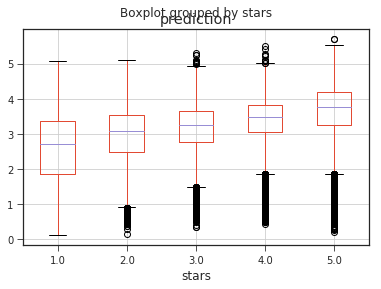

In [164]:
#fit and predict
model = als.fit(train_df)
predictions = model.transform(test_df)
predictions_df = predictions.toPandas()
predictions_df.boxplot('prediction','stars')

In [165]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='stars')
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
evaluator = RegressionEvaluator(metricName='r2', labelCol='stars')
r2 = evaluator.evaluate(predictions)
print("r2 = " + str(r2))

Root-mean-square error = 1.36917406099
r2 = -0.105729516327


In [166]:
# Generate top 10 restaurant recommendations for top 10 users
userRecs = model.recommendForAllUsers(10).limit(10)
userRecs_DF = (userRecs
  .select("user_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("user_id_int", "recommendation.*")
)
userRecs_DF2 = userRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','Restaurant_name'), on='business_id_int', how ='inner')
userRecs_df2 = userRecs_DF2.toPandas()
print('top 10 restaurant recommendations for first 10 users')
print(userRecs_df2.sort_values(['user_name','rating'],ascending=[True,False]).head(20))

top 10 restaurant recommendations for first 10 users
    business_id_int  user_id_int    rating user_name  \
39              227        13840  4.845730  Big Bite   
38             1115        13840  4.439530  Big Bite   
37             6887        13840  4.382825  Big Bite   
36            14077        13840  4.317901  Big Bite   
35            25085        13840  4.310099  Big Bite   
34             1041        13840  4.292558  Big Bite   
33            58042        13840  4.290430  Big Bite   
32            11172        13840  4.270259  Big Bite   
31             6300        13840  4.258626  Big Bite   
30            40792        13840  4.244965  Big Bite   
79              227        18654  5.928578      Chad   
78             6887        18654  5.483473      Chad   
77             1115        18654  5.441483      Chad   
76            21139        18654  5.423409      Chad   
75            11223        18654  5.403385      Chad   
74            40792        18654  5.376188      Cha

In [167]:
# Generate top 10 iser recommendations for top 10 restaurant
restaurantRecs = model.recommendForAllItems(10).limit(10)
restaurantRecs_DF = (restaurantRecs
  .select("business_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("business_id_int", "recommendation.*")
)
restaurantRecs_DF2 = restaurantRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','Restaurant_name'), on='business_id_int', how ='inner')
restaurantRecs_df2 = restaurantRecs_DF2.toPandas()
print('top 10 user recommendations for first 10 restaurants')
print(restaurantRecs_df2.sort_values(['Restaurant_name','rating'],ascending=[True,False]).head(20))

top 10 user recommendations for first 10 restaurants
    business_id_int  user_id_int    rating   user_name  \
78            14832      1221061  6.368775        Seth   
0             14832        10471  6.271458     Michael   
89            14832      1395907  6.255692   Viridiana   
59            14832       944781  5.949738        Pete   
97            14832      1582364  5.949738         Mel   
38            14832       587543  5.942621        John   
37            14832       558654  5.911818       Nancy   
69            14832      1136254  5.890012     Rebecca   
30            14832       415548  5.860706     maryann   
86            14832      1356622  5.843882     Gerardo   
99             5803      1590193  4.751997      Gordon   
76             5803      1221061  4.749960        Seth   
45             5803       662985  4.622796       Janee   
54             5803       833000  4.598749   Alejandra   
23             5803       317325  4.588148    Sterling   
34             5803

#### - Scottsdale

In [168]:
ratings = df_sco.select('user_id_int','business_id_int','Restaurant_name','user_name','stars')
train_df, test_df = ratings.randomSplit([.8,.2],seed=1)
als = ALS(maxIter=10, regParam=0.3, userCol="user_id_int", itemCol="business_id_int", ratingCol="stars",
          coldStartStrategy="drop", rank=10, nonnegative = True)

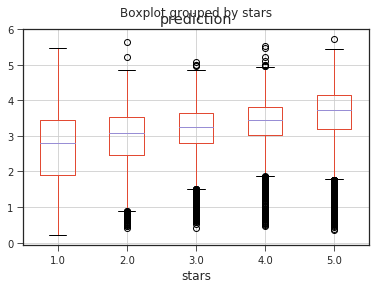

In [169]:
#fit and predict
model = als.fit(train_df)
predictions = model.transform(test_df)
predictions_df = predictions.toPandas()
predictions_df.boxplot('prediction','stars')

In [170]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='stars')
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
evaluator = RegressionEvaluator(metricName='r2', labelCol='stars')
r2 = evaluator.evaluate(predictions)
print("r2 = " + str(r2))

Root-mean-square error = 1.38957978676
r2 = -0.176092053718


In [171]:
# Generate top 10 restaurant recommendations for top 10 users
userRecs = model.recommendForAllUsers(10).limit(10)
userRecs_DF = (userRecs
  .select("user_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("user_id_int", "recommendation.*")
)
userRecs_DF2 = userRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','Restaurant_name'), on='business_id_int', how ='inner')
userRecs_df2 = userRecs_DF2.toPandas()
print('top 10 restaurant recommendations for first 10 users')
print(userRecs_df2.sort_values(['user_name','rating'],ascending=[True,False]).head(20))

top 10 restaurant recommendations for first 10 users
    business_id_int  user_id_int    rating user_name  \
9             17019         1591  5.660985     Allan   
8             46683         1591  5.554555     Allan   
7             34607         1591  5.382287     Allan   
6              2784         1591  5.238028     Allan   
5              3403         1591  5.150914     Allan   
4             29882         1591  5.149033     Allan   
3             22972         1591  5.101248     Allan   
2             56007         1591  5.086661     Allan   
1             27215         1591  5.054380     Allan   
0             10438         1591  5.048382     Allan   
19            17019         6654  1.183714      Amos   
18            34607         6654  1.147647      Amos   
17            17003         6654  1.079586      Amos   
16             2784         6654  1.071065      Amos   
15            31023         6654  1.058886      Amos   
14             5246         6654  1.056214      Amo

In [172]:
# Generate top 10 iser recommendations for top 10 restaurant
restaurantRecs = model.recommendForAllItems(10).limit(10)
restaurantRecs_DF = (restaurantRecs
  .select("business_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("business_id_int", "recommendation.*")
)
restaurantRecs_DF2 = restaurantRecs_DF.join(df_user.select('user_id_int','user_name'), on='user_id_int', how ='inner').join(df_business.select('business_id_int','Restaurant_name'), on='business_id_int', how ='inner')
restaurantRecs_df2 = restaurantRecs_DF2.toPandas()
print('top 10 user recommendations for first 10 restaurants')
print(restaurantRecs_df2.sort_values(['Restaurant_name','rating'],ascending=[True,False]).head(20))

top 10 user recommendations for first 10 restaurants
    business_id_int  user_id_int    rating    user_name  \
48            18218       841085  5.559584      Whitney   
9             18218       217569  5.491880         Anne   
83            18218      1420372  5.371397       Sruthi   
35            18218       754390  5.280823       Linnea   
0             18218        22339  5.265948  SocialMedia   
15            18218       418161  5.265948        Jason   
16            18218       428635  5.265948      Martina   
24            18218       571386  5.265948        Shyla   
58            18218      1157586  5.265948        Jason   
63            18218      1186232  5.265948            A   
32            43688       695858  5.633283         Cody   
50            43688       871990  5.606009      Whitney   
69            43688      1207266  5.589047        Chris   
19            43688       468218  5.510040        Tatum   
91            43688      1475030  5.423231         Dave   
88 

### 2. Tuning ALS Parameters

In [173]:
# https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1
def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
#             als = ALS().setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            als = ALS(maxIter=maxIter, regParam=reg, userCol="user_id_int", itemCol="business_id_int", ratingCol="stars",
                      coldStartStrategy="drop", nonnegative = True, rank = rank)
            # train ALS model
            model = als.fit(train_data)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="stars",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [174]:
best_model = tune_ALS(train_df, test_df, maxIter = 10, regParams=[0.01, 0.3,0.8], ranks=[10,20])

10 latent factors and regularization = 0.01: validation RMSE is 1.9398789801
10 latent factors and regularization = 0.3: validation RMSE is 1.38957978676
10 latent factors and regularization = 0.8: validation RMSE is 1.48457522859
20 latent factors and regularization = 0.01: validation RMSE is 1.95639396207
20 latent factors and regularization = 0.3: validation RMSE is 1.39278288073
20 latent factors and regularization = 0.8: validation RMSE is 1.48475456125

The best model has 10 latent factors and regularization = 0.3


##### In order to save space, the parameters of best model have already been applied to the above models.

## Association Mining

In [175]:
from pyspark.sql.functions import collect_set, col, count

In [176]:
user_categories = df.select('user_id_int', 'categories')
user_cat = user_categories.groupby('user_id_int').agg(collect_set('categories').alias('categories'))
user_cat.createOrReplaceTempView('user_cat')
user_cat.show(truncate=100)

+-----------+----------------------------------------------------------------------------------------------------+
|user_id_int|                                                                                          categories|
+-----------+----------------------------------------------------------------------------------------------------+
|        463|                                                                                             [Pizza]|
|        496|                                       [CocktailBars,Nightlife,Southern,Bars,Salad,Breakfast&Brunch]|
|       1088|                                                                             [American(Traditional)]|
|       1238|[Burgers,American(Traditional), American(Traditional),HotDogsBurgers, Bars,Italian,WineBarsNightl...|
|       1342|                                                            [Breakfast&BrunchBagels,Food,Coffee&Tea]|
|       1580|                                                                   

### 1. Frequent Itemsets

In [177]:
from pyspark.ml.fpm import FPGrowth

#set the minimum thresholds for support and confidence
fpGrowth = FPGrowth(itemsCol="categories", minSupport=0.001, minConfidence=0)

model = fpGrowth.fit(user_cat)

#Calculate frequent itemsets
mostPopularCategory = model.freqItemsets
mostPopularCategory.createOrReplaceTempView("mostPopularCategory")

# Display frequent itemsets.
model.freqItemsets.show(truncate =False)

+-----------------------------------------------------------------------------------------+-----+
|items                                                                                    |freq |
+-----------------------------------------------------------------------------------------+-----+
|[EventPlanning&Services,Caterers,Nightlife,Pubs,Bars,British]                            |1623 |
|[Mexican]                                                                                |80361|
|[Pizza]                                                                                  |46261|
|[Pizza, Mexican]                                                                         |9970 |
|[Mexican,Chinese,AsianFusion]                                                            |1620 |
|[Chinese]                                                                                |43545|
|[Chinese, Pizza]                                                                         |6565 |
|[Chinese, Pizza, Me

In [178]:
#only show item groups larger than 2
spark.sql('''select items, freq from mostPopularCategory 
          where size(items) > 2 order by freq desc limit 20''').show(truncate =False)

+---------------------------------------+----+
|items                                  |freq|
+---------------------------------------+----+
|[Chinese, Pizza, Mexican]              |3450|
|[Thai, Chinese, Mexican]               |2851|
|[Italian, Pizza, Mexican]              |2802|
|[Italian, Chinese, Mexican]            |2645|
|[Thai, Pizza, Mexican]                 |2642|
|[Thai, Italian, Mexican]               |2272|
|[Burgers, Pizza, Mexican]              |2100|
|[Italian, Chinese, Pizza]              |2093|
|[Vietnamese, Chinese, Mexican]         |2078|
|[Thai, Chinese, Pizza]                 |2063|
|[Burgers, Chinese, Mexican]            |2010|
|[Breakfast&Brunch, Pizza, Mexican]     |1938|
|[Thai, Italian, Chinese]               |1898|
|[Vietnamese, Thai, Mexican]            |1896|
|[American(Traditional), Pizza, Mexican]|1849|
|[Breakfast&Brunch, Chinese, Mexican]   |1827|
|[Vietnamese, Thai, Chinese]            |1823|
|[Thai, Italian, Pizza]                 |1786|
|[Burgers, It

### 2. Association Rules

In [179]:
model.associationRules.show(25, truncate=False)

+------------------------------+-----------------------+-------------------+
|antecedent                    |consequent             |confidence         |
+------------------------------+-----------------------+-------------------+
|[Breakfast&Brunch, Mexican]   |[Chinese]              |0.38544303797468354|
|[Breakfast&Brunch, Mexican]   |[Thai]                 |0.32531645569620254|
|[Breakfast&Brunch, Mexican]   |[Pizza]                |0.4088607594936709 |
|[Breakfast&Brunch, Mexican]   |[Italian]              |0.3392405063291139 |
|[Breakfast&Brunch, Mexican]   |[Burgers]              |0.25738396624472576|
|[Vietnamese, Chinese, Mexican]|[Thai]                 |0.559191530317613  |
|[Pizza,Italian, Mexican]      |[Chinese]              |0.3722943722943723 |
|[Pizza,Italian, Mexican]      |[Thai]                 |0.306340718105424  |
|[Pizza,Italian, Mexican]      |[Pizza]                |0.403615991851286  |
|[Pizza,Italian, Mexican]      |[Italian]              |0.33868092691622104|

In [180]:
#sort by confidence
model.associationRules.orderBy("confidence", ascending=False).show(25, truncate=False)

+--------------------------------+----------+------------------+
|antecedent                      |consequent|confidence        |
+--------------------------------+----------+------------------+
|[Burgers, Chinese, Pizza]       |[Mexican] |0.7200488997555012|
|[Thai, Italian, Pizza]          |[Mexican] |0.7122060470324748|
|[Italian, Chinese, Pizza]       |[Mexican] |0.7090301003344481|
|[Thai, Chinese, Pizza]          |[Mexican] |0.7014057198254968|
|[Thai, Italian, Chinese]        |[Mexican] |0.6875658587987356|
|[American(Traditional), Thai]   |[Mexican] |0.6561866125760649|
|[Korean, Japanese]              |[Chinese] |0.6418324849606664|
|[American(New), Thai]           |[Mexican] |0.6404819277108433|
|[American(New), Chinese]        |[Mexican] |0.6392872664059105|
|[Sandwiches, Chinese]           |[Mexican] |0.6378100140383716|
|[Vietnamese, Thai, Chinese]     |[Mexican] |0.6374108612177729|
|[Pizza,Italian, Thai]           |[Mexican] |0.6354992076069731|
|[Korean, Vietnamese]    

In [181]:
model.associationRules.orderBy("confidence", ascending=False).toPandas().head()

antecedent consequent  confidence
0  [Burgers, Chinese, Pizza]  [Mexican]    0.720049
1     [Thai, Italian, Pizza]  [Mexican]    0.712206
2  [Italian, Chinese, Pizza]  [Mexican]    0.709030
3     [Thai, Chinese, Pizza]  [Mexican]    0.701406
4   [Thai, Italian, Chinese]  [Mexican]    0.687566

### 3. Predictions

In [182]:
model.transform(user_cat).show(truncate=70)

+-----------+----------------------------------------------------------------------+----------------------------------------------------------------------+
|user_id_int|                                                            categories|                                                            prediction|
+-----------+----------------------------------------------------------------------+----------------------------------------------------------------------+
|        463|                                                               [Pizza]|[Mexican, Chinese, Italian, Thai, Vietnamese, Breakfast&Brunch, Bur...|
|        496|         [CocktailBars,Nightlife,Southern,Bars,Salad,Breakfast&Brunch]|                                                                    []|
|       1088|                                               [American(Traditional)]|[Chinese, Vietnamese, Thai, Burgers, Pizza, American(New), Italian,...|
|       1238|[Burgers,American(Traditional), American(Traditiona

In [183]:
model.transform(user_cat).limit(10).toPandas()

user_id_int                                         categories  \
0          463                                            [Pizza]   
1          496  [CocktailBars,Nightlife,Southern,Bars,Salad,Br...   
2         1088                            [American(Traditional)]   
3         1238  [Burgers,American(Traditional), American(Tradi...   
4         1342           [Breakfast&BrunchBagels,Food,Coffee&Tea]   
5         1580                                            [Greek]   
6         1591  [Beauty&Spas,DaySpasHealthRetreats,Hotels&Trav...   
7         1645  [American(New),Casinos,Education,Arts&Entertai...   
8         1829  [Bakeries,Cupcakes,DanceSchools,SpecialtySchoo...   
9         1959  [Korean,VietnameseSeafood,Soup, Vietnamese, Sa...   

                                          prediction  
0  [Mexican, Chinese, Italian, Thai, Vietnamese, ...  
1                                                 []  
2  [Chinese, Vietnamese, Thai, Burgers, Pizza, Am...  
3                                   [Pizza, Mexican]  
4                                                 []  
5                                          [Mexican]  
6                                                 []  
7                                                 []  
8  [Chinese, Vietnamese, Thai, Burgers, Pizza, It...  
9  [Chinese, Thai, Pizza, Italian, Mexican, Break...

## Graphs

In [184]:
df_user =  spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_user.json")

In [185]:
df_user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [186]:
df_user.count()

1637138

Here I tried to filter on the column fans in order to try and get a smaller number of users to work with

In [187]:
df_user_f = df_user

In [188]:
from pyspark.sql.functions import explode
friends = df_user_f.select(['user_id', 'friends'])
friends = friends.withColumn('friends', explode(split("friends", "[,]")))

In [189]:
friends.show()

+--------------------+--------------------+
|             user_id|             friends|
+--------------------+--------------------+
|l6BmjZMeQD3rDxWUb...|c78V-rj8NQcQjOI8K...|
|l6BmjZMeQD3rDxWUb...| alRMgPcngYSCJ5na...|
|l6BmjZMeQD3rDxWUb...| ajcnq75Z5xxkvUSm...|
|l6BmjZMeQD3rDxWUb...| BSMAmp2-wMzCkhTf...|
|l6BmjZMeQD3rDxWUb...| jka10dk9ygX76hJG...|
|l6BmjZMeQD3rDxWUb...| dut0e4xvme7QSles...|
|l6BmjZMeQD3rDxWUb...| l4l5lBnK356zBua7...|
|l6BmjZMeQD3rDxWUb...| 0HicMOOs-M_gl2eO...|
|l6BmjZMeQD3rDxWUb...| _uI57wL2fLyftrcS...|
|l6BmjZMeQD3rDxWUb...| T4_Qd0YWbC3co6WS...|
|l6BmjZMeQD3rDxWUb...| iBRoLWPtWmsI1kdb...|
|l6BmjZMeQD3rDxWUb...| xjrUcid6Ymq0DoTJ...|
|l6BmjZMeQD3rDxWUb...| GqadWVzJ6At-vgLz...|
|l6BmjZMeQD3rDxWUb...| DvB13VJBmSnbFXBV...|
|l6BmjZMeQD3rDxWUb...| vRP9nQkYTeNioDjt...|
|l6BmjZMeQD3rDxWUb...| gT0A1iN3eeQ8EMAj...|
|l6BmjZMeQD3rDxWUb...| 6yCWjFPtp_AD4x93...|
|l6BmjZMeQD3rDxWUb...| 1dKzpNnib-JlViKv...|
|l6BmjZMeQD3rDxWUb...| 3Bv4_JxHXq-gVLOx...|
|l6BmjZMeQD3rDxWUb...| ikQyfu1iV

In [192]:
from graphframes import *

In [191]:
#!pip install graphframes

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [193]:
user = df_user_f.select(['user_id', 'average_stars', 'name'])
user = user.withColumn('id', user['user_id'])

user = user.drop('user_id')


In [194]:
user.show(5)

+-------------+------+--------------------+
|average_stars|  name|                  id|
+-------------+------+--------------------+
|         4.03|Rashmi|l6BmjZMeQD3rDxWUb...|
|         3.63| Jenna|4XChL029mKr5hydo7...|
|         3.71| David|bc8C_eETBWL0olvFS...|
|         4.85|Angela|dD0gZpBctWGdWo9Wl...|
|         4.08| Nancy|MM4RJAeH6yuaN8oZD...|
+-------------+------+--------------------+
only showing top 5 rows



In [195]:
friends.show(5)

+--------------------+--------------------+
|             user_id|             friends|
+--------------------+--------------------+
|l6BmjZMeQD3rDxWUb...|c78V-rj8NQcQjOI8K...|
|l6BmjZMeQD3rDxWUb...| alRMgPcngYSCJ5na...|
|l6BmjZMeQD3rDxWUb...| ajcnq75Z5xxkvUSm...|
|l6BmjZMeQD3rDxWUb...| BSMAmp2-wMzCkhTf...|
|l6BmjZMeQD3rDxWUb...| jka10dk9ygX76hJG...|
+--------------------+--------------------+
only showing top 5 rows



In [196]:
one_user = friends.withColumn('id', regexp_replace(col("friends"), " ", "")).drop('friends').filter(col('user_id') =='MM4RJAeH6yuaN8oZDSt0RA').join(user.select(['id','name']), on = 'id', how = 'inner').drop('user_id')

In [197]:
one_user.show()

+--------------------+----------+
|                  id|      name|
+--------------------+----------+
|Og1bB3jNZL_7bmgmZ...|     Ellie|
|lIdHk3mRVuktCiRoC...|    Elissa|
|zmr4gUzWiaPeEhIfe...|     Scott|
|FPPGwEsGEHdmZlWa6...|     Amina|
|ylcdzJGKqJgIZHG6U...|    Alisha|
|hncn3pyp5D3RN0-Bf...|    Nguyen|
|yuEzhI3PX4CHfCnJs...|   Daniela|
|wKpG03fFq3kIFdCYH...|       Liz|
|akiIhaV0vVVfDwEoz...|      Lori|
|vOyyDaJ2TL5x18ojm...|   Stephen|
|WuMm1tvQcnTpHxwSg...|     Katie|
|5ogD10-_oV1FDeiL4...|  Jennifer|
|JuTNpBtxh80AqTE5z...|   Melissa|
|0hDy_Y29b_Np4CidP...|    Pamela|
|mOanh--SkJagXdsfJ...|Franchesca|
|4qYuZmlndclYBVy7o...|      Jenn|
|FkOmPLXOIhb6994LD...|     Steve|
|sNi88eCKkPXQEktvd...|    Gerard|
|tQco9XTdKcErXPIfV...|      Erik|
|jwbcs_eQ2QznrOyMu...|    Rachel|
+--------------------+----------+
only showing top 20 rows



In [201]:
df_business = spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_business.json")

#change name for starts to avoid duplicates
df_business=df_business.withColumnRenamed("stars", "Restaurant_stars")
df_business=df_business.withColumnRenamed("name", "Restaurant_name")
df_business=df_business.filter(psf.col('categories').rlike('Restaurants'))
df_business = df_business.select('*','attributes.*','hours.*')
columns_to_drop = ['address','postal_code','review_count','attributes','hours']
df_business = df_business.drop(*columns_to_drop)

df_business = df_business.withColumn('categories', regexp_replace(col("categories"), "(,?\ ?Restaurants,?)", ""))
df_business = df_business.withColumn('categories', regexp_replace(col("categories"), "( ?)", ""))

In [202]:
df_business1 = df_business.select(['business_id','categories','Restaurant_name']).withColumn('category', explode(split("categories", "[,]"))).drop('categories')

In [203]:
df_business1.show()

+--------------------+--------------------+--------------------+
|         business_id|     Restaurant_name|            category|
+--------------------+--------------------+--------------------+
|QXAEGFB4oINsVuTFx...|Emerald Chinese R...| SpecialtyFoodDimSum|
|QXAEGFB4oINsVuTFx...|Emerald Chinese R...|        ImportedFood|
|QXAEGFB4oINsVuTFx...|Emerald Chinese R...|                Food|
|QXAEGFB4oINsVuTFx...|Emerald Chinese R...|             Chinese|
|QXAEGFB4oINsVuTFx...|Emerald Chinese R...|          EthnicFood|
|QXAEGFB4oINsVuTFx...|Emerald Chinese R...|             Seafood|
|gnKjwL_1w79qoiV3I...|Musashi Japanese ...|   SushiBarsJapanese|
|1Dfx3zM-rW4n-31Ke...|           Taco Bell|    Breakfast&Brunch|
|1Dfx3zM-rW4n-31Ke...|           Taco Bell|             Mexican|
|1Dfx3zM-rW4n-31Ke...|           Taco Bell|               Tacos|
|1Dfx3zM-rW4n-31Ke...|           Taco Bell|             Tex-Mex|
|1Dfx3zM-rW4n-31Ke...|           Taco Bell|            FastFood|
|fweCYi8FmbJXHCqLn...|   

In [204]:
df_reviews =  spark.read.json("gs://yelpreviewdataset/yelp_academic_dataset_review.json")

columns_to_drop = ['cool','funny','average_stars']
df_reviews = df_reviews.drop(*columns_to_drop)

In [205]:
my_category = 'Mexican'

In [206]:
One_user1 = df_reviews.select(['business_id', 'stars', 'user_id']).withColumnRenamed("user_id", "id").join(one_user.select(['id','name']), on = 'id', how = 'inner').join(df_business1.select(['business_id','category','Restaurant_name']).filter(df_business1.category == my_category), on = 'business_id', how = 'inner').drop('category').toPandas()

In [207]:
One_user1.head(5)

business_id                      id  stars   name  \
0  QXV3L_QFGj8r6nWX2kS2hA  zmr4gUzWiaPeEhIfeKXOvA    5.0  Scott   
1  Wcw-xq_c89e4AaRsUtkaLw  zmr4gUzWiaPeEhIfeKXOvA    4.0  Scott   
2  BIbjBxoiJLS8CnNsSP64TQ  akiIhaV0vVVfDwEozKZxEw    1.0   Lori   
3  X1Y2II3AYdoxa70nTTfUPQ  akiIhaV0vVVfDwEozKZxEw    3.0   Lori   
4  HWl2EbZhkhAkFgqt44yUkA  akiIhaV0vVVfDwEozKZxEw    1.0   Lori   

       Restaurant_name  
0          Nacho Daddy  
1       Eldorado Grill  
2  360 Gourmet Burrito  
3    Fresh Grill & Bar  
4         Senor Frog's

In [208]:
One_user1[One_user1['stars']>=4].shape

(188, 5)

Here is where I build the graph

In [209]:
#!pip install networkx

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [210]:
%matplotlib inline

import pandas as pd
import networkx as nx

In [35]:
#FG = nx.from_pandas_edgelist(One_user1[One_user1['stars']>=4], source='Restaurant_name',
                             #target='name', edge_attr='stars')

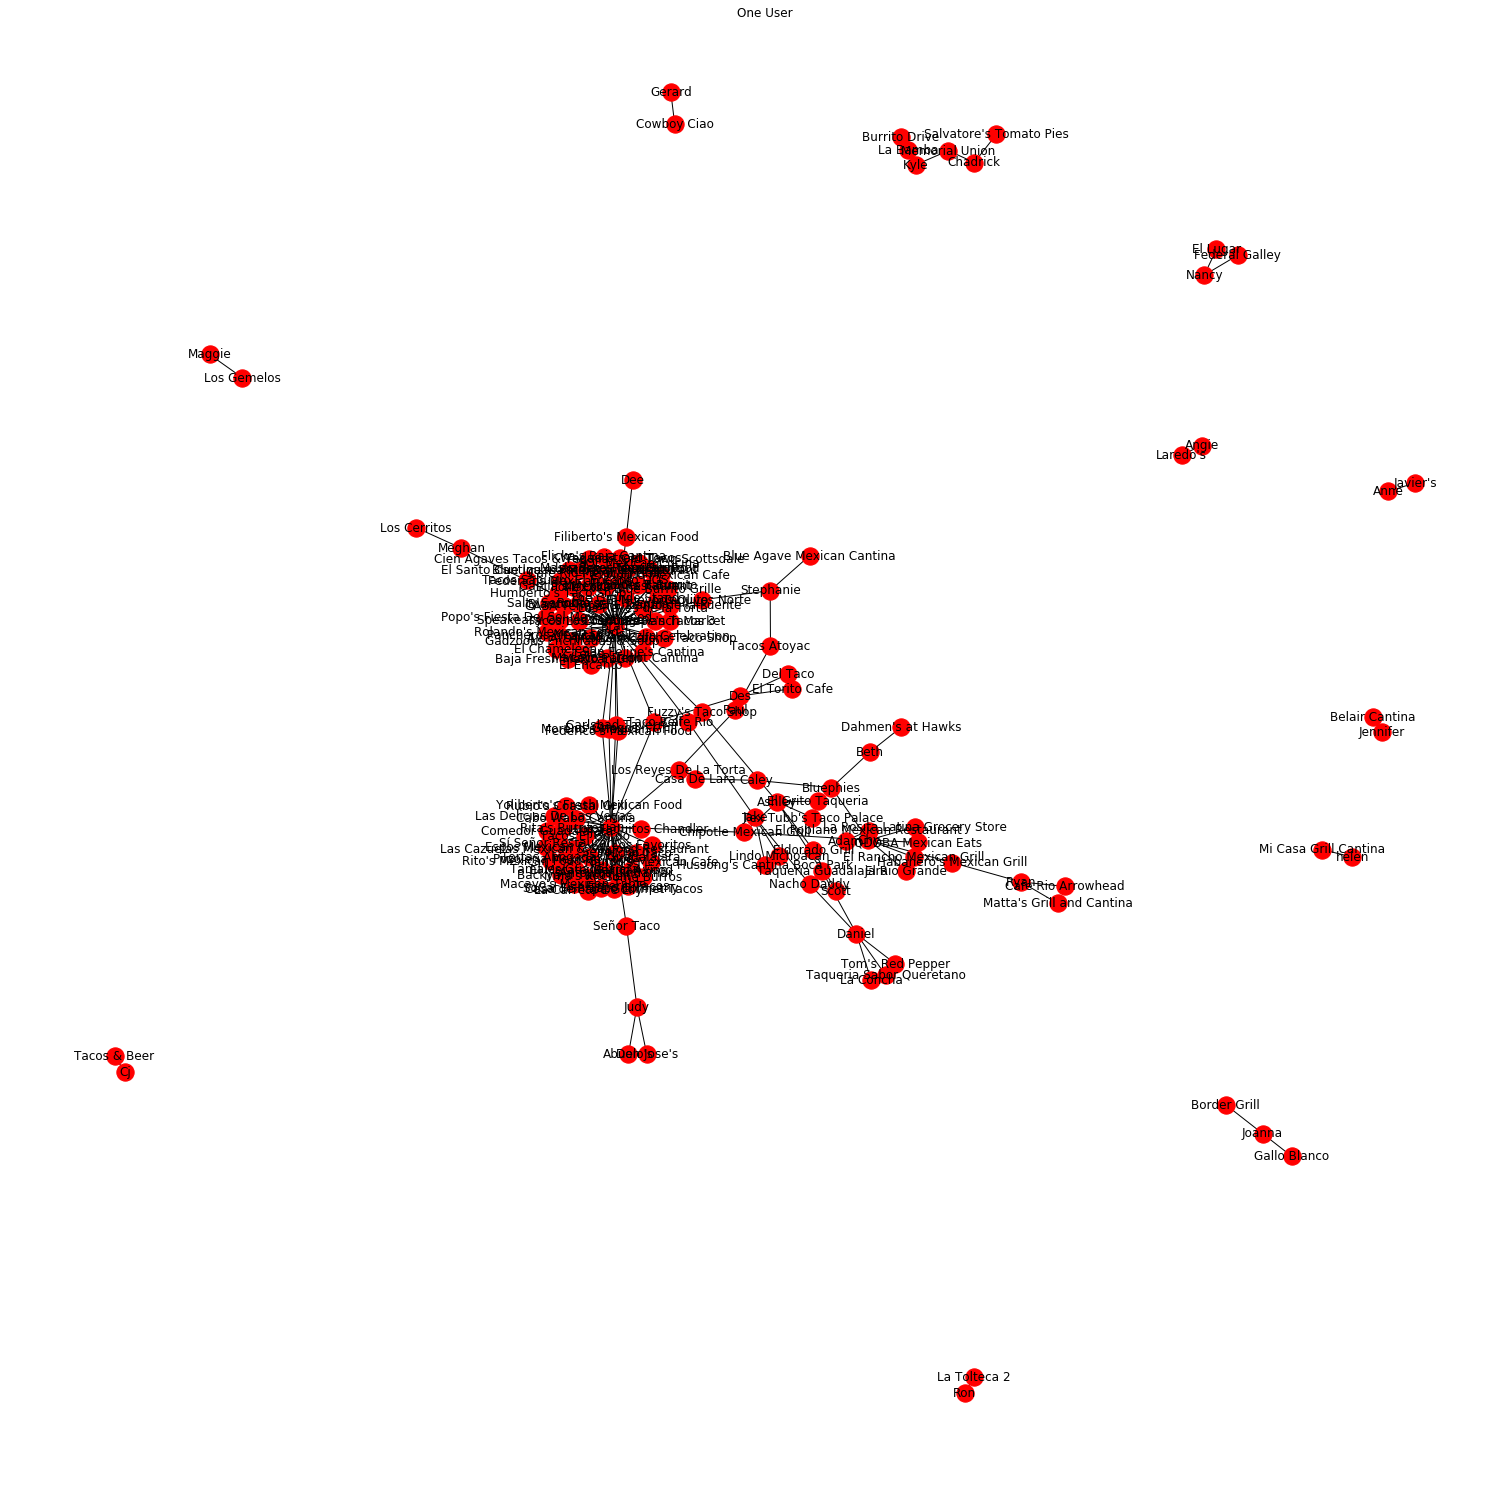

In [36]:
#plt.figure(figsize=(20,20))
#nx.draw(FG, with_labels=True)
#plt.title('One User')
#plt.show()

In [211]:
clubs = list(One_user1[One_user1['stars']>=4]['Restaurant_name'].unique())
people = list(One_user1[One_user1['stars']>=4]['name'].unique())

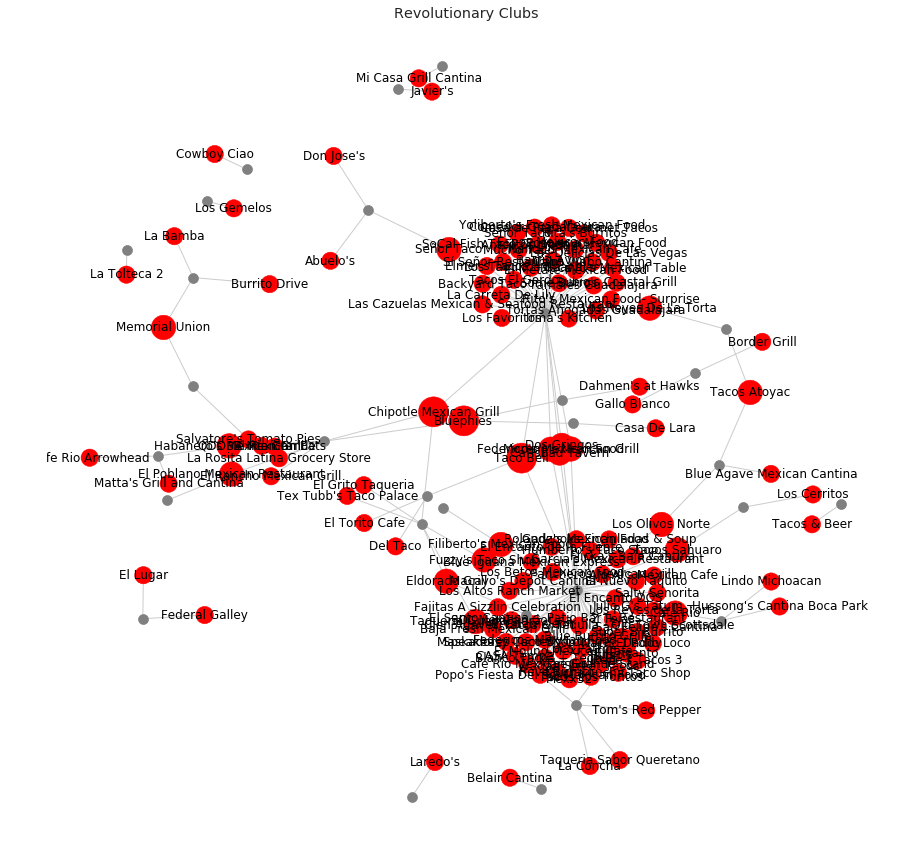

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# 1. Create the graph
g = nx.from_pandas_edgelist(One_user1[One_user1['stars']>=4], source='name',
                             target='Restaurant_name')
# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,k=0.33,iterations=100)

# 3. Draw the parts we want
# Edges thin and grey
# People small and grey
# Clubs sized according to their number of connections
# Clubs blue
# Labels for clubs ONLY
# People who are highly connected are a highlighted color

# Go through every club name, ask the graph how many
# connections it has. Multiply that by 80 to get the circle size
club_size = [g.degree(Restaurant_name) * 300 for Restaurant_name in clubs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=clubs, 
                       node_size=club_size, # a LIST of sizes, based on g.degree
                       node_color='red'
                    )


# Draw EVERYONE
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#cccccc', node_size=100)

# Draw POPULAR PEOPLE
popular_people = [person for person in people ]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='grey', node_size=100,)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(clubs, clubs))
nx.draw_networkx_labels(g, layout, labels=node_labels)

# 4. Turn off the axis because I know you don't want it
plt.axis('off')

plt.title("Revolutionary Clubs")

# 5. Tell matplotlib to show it
plt.show()